<a href="https://colab.research.google.com/github/mavalenciaor/primer-demo-de-clase/blob/master/COVID_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Definición del Problema

La propagación de una pandemia es un problema de salud pública que debe ser atendido y estudiado para evitar la difusión de la enfermedad y muerte en la mayor parte  de la población.  
En Colombia, el Ministerio de Salud, confirmó el primer caso en la ciudad de Bogotá el día 6 de marzo de 2020, a partir de esta fecha, la enfermedad empezó a propagarse en el resto de la población, por lo tanto, se debieron tomar acciones preventivas como lo fue la medida de aislamiento físico y la implementación de protocolos de seguridad, los cuales consisten en el uso de mascarilla y el alcohol desinfectante para manos y en general superficies de contacto.

# 2. Definición del problema de analítica

Para tomar medidas preventivas frente a una pandemia como la del COVID19 se requieren datos que miden, principalmente: la propagación del virus,  características de la población más susceptible al contagio (edad, género, condiciones médicas previas, ubicación, etc) y capacidad de camas en los centros hospitalarios. Otro factor a tener en cuenta es la evolución de la propagación del virus, a partir de la cantidad de recuperados, casos activos y fallecidos. Cuanto mayor sea el volumen de los datos, mejor comprensión habrá de la problemática actual, la cual abarca no solo el sector de la salud, sino también, el el sector social, económico y laboral.
El valor que la analítica le da a estos tipos de datos radica en ayudar a llevar a cabo medidas o políticas acertadas que permitan mejorar la situación en la menor cantidad de tiempo posible.
Para este ejercicio nos interesa conocer las predicciones de casos reportados, casos activos, recuperados y fallecidos por ciudades. En principio, creemos que los casos reportados, activos y recuperados van a aumentar más o menos con la misma proporción, mientras que el caso de fallecidos se mantendrá en el mismo número de casos durante cierto tiempo, hasta que finalmente empeice a decrecer. 


##2.1 Datos 

Los datos son proporcionados directamente desde la página del gobierno nacional de Colombia. La actualización de dichos datos es proporcional al número de pruebas llevadas a cabo diariamente. Estos datos contiene la descripción del caso, el lugar de residencia, la edad, el sexo, el tipo de caso y el estado final; además contiene la fechas de registro de cada estado.

##2.2 Instalación de librerías e imports

In [ ]:
pip install sodapy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins
from sodapy import Socrata

import warnings
warnings.filterwarnings('ignore')

## 2.3 Carga de datos

Carga de datos a partir de la información disponible en: www.datos.gov.co.

In [ ]:
# Socrata nos permite acceder a los datos en tiempo real
# para páginas web que no posean autenticación de usuario y contraseña
client = Socrata("www.datos.gov.co", None)

#Esta opción permite obtener el primer millón de datos en formato JSON
#convertida en una lista de diccionarios por la librería sodapy
results = client.get("gt2j-8ykr", limit = 1000000)

#Convertimos los resultados en un DataFrame de Pandas
df_results = pd.DataFrame.from_records(results)

## 2.4 Análisis exploratorio

Vistazo general del contenido del dataset.

In [ ]:
df_results.head()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380,Otro,NaN,NaN
1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000,PCR,76,724,Otro,NaN,NaN
2,3,2020-03-07T00:00:00.000,05001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724,Otro,NaN,NaN
3,4,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN
4,5,2020-03-09T00:00:00.000,05001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN,NaN


**Tomamos los datos hasta las fecha 31 de agosto, nuestra fecha de corte definida.**

In [ ]:
df_results['fecha_reporte_web'] =  pd.to_datetime(df_results['fecha_reporte_web'])
df_results = df_results.loc[df_results['fecha_reporte_web'] <= "2020-08-31"]

In [ ]:
print("La fecha mínima de los datos es: ", min(df_results['fecha_reporte_web']))
print("La fecha máxima de los datos es: ", max(df_results['fecha_reporte_web']))

La fecha mínima de los datos es:  2020-03-06 00:00:00
La fecha máxima de los datos es:  2020-08-31 00:00:00


Tamaño del dataset.

In [ ]:
df_results.shape

(615168, 21)

Alguans estadísticas.

In [ ]:
df_results.describe()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
count,615168,615168,615168,615168,615168,615168,615168,615168,615168,615168,961,615168,611192,479570,615168,479565,615168,962,281481,8139,21559
unique,615168,180,1023,949,37,6,110,4,6,6,48,626,177,172,176,2,33,43,4,88,166
top,360367,2020-07-27T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,30,M,En estudio,Leve,ESPAÑA,Asintomático,2020-08-11T00:00:00.000,2020-08-23T00:00:00.000,2020-08-19 00:00:00,Tiempo,11,724,Otro,ZENÚ,2020-07-30T00:00:00.000
freq,1,12106,211300,211300,211300,479565,16498,316111,582969,496156,265,73379,17433,14152,13056,387727,211300,265,253968,1839,370
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


Conteo de valores nulos por columna.

In [ ]:
df_results.isnull().sum()

id_de_caso                    0
fecha_de_notificaci_n         0
c_digo_divipola               0
ciudad_de_ubicaci_n           0
departamento                  0
atenci_n                      0
edad                          0
sexo                          0
tipo                          0
estado                        0
pa_s_de_procedencia      614207
fis                           0
fecha_diagnostico          3976
fecha_recuperado         135598
fecha_reporte_web             0
tipo_recuperaci_n        135603
codigo_departamento           0
codigo_pais              614206
pertenencia_etnica       333687
nombre_grupo_etnico      607029
fecha_de_muerte          593609
dtype: int64

Obervamos los tipos de atención y cuántas veces ocurre cada uno.

In [ ]:
df_results['atenci_n'].value_counts()

Recuperado      479565
Casa             91932
Hospital         20396
Fallecido        20284
Hospital UCI      1676
N/A               1315
Name: atenci_n, dtype: int64

Observamos los tipos de datos para cada una de las columnas.

In [ ]:
df_results.dtypes

id_de_caso                       object
fecha_de_notificaci_n            object
c_digo_divipola                  object
ciudad_de_ubicaci_n              object
departamento                     object
atenci_n                         object
edad                             object
sexo                             object
tipo                             object
estado                           object
pa_s_de_procedencia              object
fis                              object
fecha_diagnostico                object
fecha_recuperado                 object
fecha_reporte_web        datetime64[ns]
tipo_recuperaci_n                object
codigo_departamento              object
codigo_pais                      object
pertenencia_etnica               object
nombre_grupo_etnico              object
fecha_de_muerte                  object
dtype: object

Realizamos conversiones para tener las fechas en el formato adecuado.

In [ ]:
# Conversión de objetos a fechas
df_covid_all = df_results.copy()

Realizamos una conversión del formato de las fechas.

In [ ]:
df_covid_all['fecha_diagnostico'] =  pd.to_datetime(df_covid_all
                                                    ['fecha_diagnostico'])
df_covid_all['fecha_recuperado'] =  pd.to_datetime(df_covid_all
                                                    ['fecha_recuperado'])
df_covid_all['fecha_de_muerte'] =  pd.to_datetime(df_covid_all
                                                    ['fecha_de_muerte'])

In [ ]:
df_covid_all.dtypes

id_de_caso                       object
fecha_de_notificaci_n            object
c_digo_divipola                  object
ciudad_de_ubicaci_n              object
departamento                     object
atenci_n                         object
edad                             object
sexo                             object
tipo                             object
estado                           object
pa_s_de_procedencia              object
fis                              object
fecha_diagnostico        datetime64[ns]
fecha_recuperado         datetime64[ns]
fecha_reporte_web        datetime64[ns]
tipo_recuperaci_n                object
codigo_departamento              object
codigo_pais                      object
pertenencia_etnica               object
nombre_grupo_etnico              object
fecha_de_muerte          datetime64[ns]
dtype: object

Analizaremos la cantidad de casos activos, recuperados y fallecidos para cada una de las fechas. Pero primero es importante hacer una anotación sobre algunos casos.

In [ ]:
df_covid_all["atenci_n"].value_counts()

Recuperado      479565
Casa             91932
Hospital         20396
Fallecido        20284
Hospital UCI      1676
N/A               1315
Name: atenci_n, dtype: int64

Es posible observar que tenemos algunos registros que cuentan con valores "N/A" en la columna atención.

In [ ]:
(df_covid_all["atenci_n"] == "N/A").value_counts()

False    613853
True       1315
Name: atenci_n, dtype: int64

In [ ]:
len(df_covid_all[(df_covid_all["atenci_n"] == "N/A") & (df_covid_all["fecha_de_muerte"].notnull())])

1104

Si detallamos un poco más estos casos, notamos que en la mayoría de ocasiones tenemos una fecha de muerte asociada a ellos, además, según lo indicado en las cifras oficiales del gobierno, el número de filas con N/A en "atención" corresponde a la cifra de muertos no COVID, por lo que decidimos eliminar estos registros del conjunto de datos a analizar.

In [ ]:
df_covid_all.loc[(df_covid_all["atenci_n"] == "N/A")].head(5)

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
790,791,2020-03-26T00:00:00.000,76520,Palmira,Valle del Cauca,N/A,88,M,Relacionado,Asintomático,NaN,Asintomático,2020-03-30,NaT,2020-03-30,NaN,76,NaN,Otro,NaN,2020-06-10
928,929,2020-03-27T00:00:00.000,25817,Tocancipá,Cundinamarca,N/A,39,M,En estudio,N/A,NaN,2020-03-25T00:00:00.000,2020-04-01,NaT,2020-04-01,NaN,25,NaN,Otro,NaN,2020-05-03
2797,2798,2020-04-10T00:00:00.000,47001,Santa Marta,Santa Marta D.T. y C.,N/A,42,M,En estudio,N/A,NaN,2020-04-01T00:00:00.000,2020-04-13,NaT,2020-04-13,NaN,47,NaN,Otro,NaN,2020-05-02
2858,2859,2020-04-11T00:00:00.000,13001,Cartagena de Indias,Cartagena D.T. y C.,N/A,17,M,Relacionado,N/A,NaN,2020-03-26T00:00:00.000,2020-04-14,NaT,2020-04-14,NaN,13,NaN,Otro,NaN,2020-04-17
3084,3085,2020-04-13T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,N/A,77,M,En estudio,N/A,NaN,2020-04-10T00:00:00.000,2020-04-15,NaT,2020-04-15,NaN,11,NaN,Otro,NaN,NaT


In [ ]:
# df_only_covid
df_only_covid = df_covid_all.copy()
df_only_covid = df_only_covid[df_only_covid.atenci_n != "N/A"]
print("Cantidad de filas originales: ", len(df_covid_all))
print("Cantidad de filas después de la eliminación: ", len(df_only_covid))

Cantidad de filas originales:  615168
Cantidad de filas después de la eliminación:  613853


Según lo establecido en los objetivos del desarrollo, se busca realizar predicciones relativas a la evolución del COVID para las principales ciudades de Colombia, en nuestro caso definimos que éstas son: Bogotá, Medellín, Cali y Barranquilla.

Inicialmente, realizamos un conteo de casos por ciudad para toda Colombia.


In [ ]:
df_only_covid["ciudad_de_ubicaci_n"].value_counts()

Bogotá D.C.            210958
Medellín                47263
Cali                    36773
Barranquilla            36027
Cartagena de Indias     20409
                        ...  
Confines                    1
Cuítiva                     1
Guataquí                    1
Uribe                       1
Vegachí                     1
Name: ciudad_de_ubicaci_n, Length: 948, dtype: int64

A partir de la información extraída crearemos una estructura de datos para cada ciudad de interés y realizaremos procesos de agrupamiento para calcular la cantidad de casos reportados, recuperados y fallecidos para cada día, también se realizarán cálculos casos activos, recuperados y fallecidos acumulados.

In [ ]:
# Agrupamiento de casos en el país 

def SumCases(df_cv):
  # Casos reportados
  df_rep_cases = df_cv.groupby('fecha_reporte_web').agg({ 
                                          'id_de_caso': 'count' 
                                          })

  df_rep_cases.rename(columns={'id_de_caso':'reportados'}, inplace=True)

  # Fallecidos
  df_fal_cases = df_cv.groupby('fecha_de_muerte').agg({ 
                                          'id_de_caso': 'count' 
                                          })
  df_fal_cases.rename(columns={'id_de_caso':'fallecidos'}, inplace=True)

  # Recuperados
  df_rec_cases = df_cv.groupby('fecha_recuperado').agg({ 
                                          'id_de_caso': 'count' 
                                          })
  df_rec_cases.rename(columns={'id_de_caso':'recuperados'}, inplace=True)

  # Personas que se recuperaron y posteriormente murieron
  df_muer_desp_rec = df_cv.loc[(df_cv["fecha_de_muerte"].notnull()) & (df_cv["atenci_n"] != "Fallecido")]
  df_muer_esp_cases = df_muer_desp_rec.groupby('fecha_de_muerte').agg({ 
                                          'id_de_caso': 'count' 
                                          })
  df_muer_esp_cases.rename(columns={'id_de_caso':'muerto_desp_rec'}, inplace=True)

  # Unión de casos (reportados, fallecidos, recuperados)
  df_sum_cases = df_rep_cases.join(df_fal_cases, lsuffix='_caller', rsuffix='_other').join(df_rec_cases, lsuffix='_caller', rsuffix='_other').join(df_muer_esp_cases, lsuffix='_caller', rsuffix='_other').fillna(0).astype(int)
  df_sum_cases.index.names = ['fecha']
  df_sum_cases.reset_index(inplace=True)
  
  return df_sum_cases

In [ ]:
# Cálculo de casos totales

def TotalCases(df_sum):

  casos_activos = []
  recuperados = []
  fallecidos = []
  acum = 0
  sum_rec = 0
  sum_fal = 0
  for index, row in df_sum.iterrows():
    
    # Activos
    sum = acum + row['reportados'] - row['fallecidos'] - row['recuperados'] + row['muerto_desp_rec'] 
    acum = sum
    casos_activos.append(sum)

    # Recuperados
    sum_rec = sum_rec + row['recuperados']
    recuperados.append(sum_rec)

    # Fallecidos
    sum_fal = sum_fal + row['fallecidos'] - row['muerto_desp_rec'] 
    fallecidos.append(sum_fal)

  df_sum ['activos'] = casos_activos
  df_sum ['tot_recuperados'] = recuperados
  df_sum ['tot_fallecidos'] = fallecidos
  
  return(df_sum)

###2.4.1 Casos en Colombia

Iniciamos con una estructura que guarda todos los datos diarios y acumulados de todo Colombia.

In [ ]:
# Cálculo de casos en toda Colombia

df_col_sum_cases = SumCases(df_only_covid)
df_col_sum_cases = TotalCases(df_col_sum_cases)
df_col_sum_cases

,fecha,reportados,fallecidos,recuperados,muerto_desp_rec,activos,tot_recuperados,tot_fallecidos
0,2020-03-06,1,0,0,0,1,0,0
1,2020-03-09,2,0,0,0,3,0,0
2,2020-03-11,6,0,0,0,9,0,0
3,2020-03-12,5,0,0,0,14,0,0
4,2020-03-13,5,0,1,0,18,1,0
...,...,...,...,...,...,...,...,...
171,2020-08-27,9740,257,10937,3,144213,417126,19389
172,2020-08-28,8491,215,12307,1,140183,429433,19603
173,2020-08-29,9391,209,11114,9,138260,440547,19803
174,2020-08-30,8019,167,10152,8,135968,450699,19962


###2.4.2 Casos en Bogotá

Se genera un dataframe para Bogotá y se calculan estadísticas de la ciudad.

In [ ]:
# Cálculo de casos en Bogotá

df_covid_bog = df_only_covid.loc[df_only_covid["ciudad_de_ubicaci_n"] == "Bogotá D.C."]
df_bog_sum_cases = SumCases(df_covid_bog)
df_bog_sum_cases = TotalCases(df_bog_sum_cases)
df_bog_sum_cases

,fecha,reportados,fallecidos,recuperados,muerto_desp_rec,activos,tot_recuperados,tot_fallecidos
0,2020-03-06,1,0,0,0,1,0,0
1,2020-03-11,2,0,0,0,3,0,0
2,2020-03-12,2,0,0,0,5,0,0
3,2020-03-13,1,0,1,0,5,1,0
4,2020-03-14,10,0,1,0,14,2,0
...,...,...,...,...,...,...,...,...
170,2020-08-27,2518,79,3475,1,60344,135848,5355
171,2020-08-28,2181,49,5426,0,57050,141274,5404
172,2020-08-29,3337,64,4212,2,56113,145486,5466
173,2020-08-30,1845,52,3190,3,54719,148676,5515


###2.4.3 Casos en Medellín

Se genera un dataframe para Medellín y se calculan estadísticas de la ciudad.

In [ ]:
# Cálculo de casos en Medellín

df_covid_med = df_only_covid.loc[df_only_covid["ciudad_de_ubicaci_n"] == "Medellín"]
df_med_sum_cases = SumCases(df_covid_med)
df_med_sum_cases = TotalCases(df_med_sum_cases)
df_med_sum_cases

,fecha,reportados,fallecidos,recuperados,muerto_desp_rec,activos,tot_recuperados,tot_fallecidos
0,2020-03-09,1,0,0,0,1,0,0
1,2020-03-11,2,0,0,0,3,0,0
2,2020-03-14,2,0,0,0,5,0,0
3,2020-03-15,1,0,1,0,5,1,0
4,2020-03-19,3,0,0,0,8,1,0
...,...,...,...,...,...,...,...,...
161,2020-08-27,720,23,783,0,11145,31958,900
162,2020-08-28,1014,20,693,0,11446,32651,920
163,2020-08-29,754,17,906,2,11279,33557,935
164,2020-08-30,569,16,929,0,10903,34486,951


###2.4.4 Casos en Cali

Se genera un dataframe para Cali y se calculan estadísticas de la ciudad.

In [ ]:
# Cálculo de casos en Cali

df_covid_cal = df_only_covid.loc[df_only_covid["ciudad_de_ubicaci_n"] == "Cali"]
df_cal_sum_cases = SumCases(df_covid_cal)
df_cal_sum_cases = TotalCases(df_cal_sum_cases)
df_cal_sum_cases

,fecha,reportados,fallecidos,recuperados,muerto_desp_rec,activos,tot_recuperados,tot_fallecidos
0,2020-03-13,1,0,0,0,1,0,0
1,2020-03-16,2,0,0,0,3,0,0
2,2020-03-17,5,0,0,0,8,0,0
3,2020-03-20,1,0,0,0,9,0,0
4,2020-03-21,6,0,0,0,15,0,0
...,...,...,...,...,...,...,...,...
162,2020-08-27,396,14,696,0,7639,26571,1227
163,2020-08-28,368,17,511,1,7480,27082,1243
164,2020-08-29,326,12,686,1,7109,27768,1254
165,2020-08-30,334,19,628,2,6798,28396,1271


###2.4.5 Casos en Barranquilla

Se genera un dataframe para Barranquilla y se calculan estadísticas de la ciudad.

In [ ]:
# Cálculo de casos en Barranquilla

df_covid_bar = df_only_covid.loc[df_only_covid["ciudad_de_ubicaci_n"] == "Barranquilla"]
df_bar_sum_cases = SumCases(df_covid_bar)
df_bar_sum_cases = TotalCases(df_bar_sum_cases)
df_bar_sum_cases

,fecha,reportados,fallecidos,recuperados,muerto_desp_rec,activos,tot_recuperados,tot_fallecidos
0,2020-03-16,2,0,0,0,2,0,0
1,2020-03-19,3,0,0,0,5,0,0
2,2020-03-21,2,0,0,0,7,0,0
3,2020-03-24,2,0,2,0,7,2,0
4,2020-03-25,3,0,1,0,9,3,0
...,...,...,...,...,...,...,...,...
155,2020-08-27,127,3,247,1,2214,31922,1609
156,2020-08-28,71,5,380,0,1900,32302,1614
157,2020-08-29,64,2,163,1,1800,32465,1615
158,2020-08-30,85,4,273,3,1611,32738,1616


##2.5 Análisis de tipos de casos

### 2.5.1 Colombia

Ahora veremos un panorama general de Colombia.

La cantidad de casos reportados cada día en el país son:

In [ ]:
import plotly
plotly.io.renderers.default = 'colab'
import plotly.express as px

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_col_sum_cases['fecha'], 
                         y=df_col_sum_cases['reportados'], mode=
                         'lines+markers', name='Casos reportados'))
fig.update_layout(title_text="Reporte por día de casos en Colombia", plot_bgcolor='rgb(230, 230, 230)')
fig.show()

En cuanto a la cantidad de recuperados diarios tenemos:

In [ ]:
fig = px.bar(df_col_sum_cases, x="fecha", y="recuperados", barmode="group", height=400)
fig.update_layout(title_text="Cantidad de recuperados por día en Colombia", plot_bgcolor='rgb(230, 230, 230)')

fig.show()


Realizamos un análisis de activos, recuperados y fallecidos por día en Colombia:

In [ ]:
# Gráfica de acumulados por día 

def AcumDiaGraf(df_sum_cases, lugar):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=df_sum_cases ['fecha'], y=df_sum_cases ['activos'], mode="lines+markers", name="Activos", line=dict(color="Blue")))
  fig.add_trace(go.Scatter(x=df_sum_cases ['fecha'], y=df_sum_cases ['tot_recuperados'], mode="lines+markers", name="Recuperados", line=dict(color="Green")))
  fig.add_trace(go.Scatter(x=df_sum_cases ['fecha'], y=df_sum_cases ['tot_fallecidos'], mode="lines+markers", name="Fallecidos", line=dict(color="Red")))
  fig.update_layout(title='Casos acumulados en '+lugar+' por día', xaxis_tickfont_size=14, xaxis=dict(title='Fecha'), yaxis=dict(title='Cantidad de casos'),   
                    legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01
                ))
  return(fig)

In [ ]:
acum_col = AcumDiaGraf(df_col_sum_cases, "Colombia")
acum_col

Realizamos el análisis equivalente para las ciudades seleccionadas.

###2.5.2 Bogotá

In [ ]:
acum_bog = AcumDiaGraf(df_bog_sum_cases, "Bogotá")
acum_bog

###2.5.3 Medellín

In [ ]:
acum_med = AcumDiaGraf(df_med_sum_cases, "Medellín")
acum_med

###2.5.4 Cali

In [ ]:
acum_cal = AcumDiaGraf(df_cal_sum_cases, "Cali")
acum_cal

###2.5.5 Barranquilla

In [ ]:
acum_bar = AcumDiaGraf(df_bar_sum_cases, "Barranquilla")
acum_bar

Si miramos activos y total de recuperados y fallecidos, tenemos que:

In [ ]:
tot_casos_cids = pd.concat([df_bog_sum_cases.iloc[[-1]], 
                            df_med_sum_cases.iloc[[-1]], 
                            df_cal_sum_cases.iloc[[-1]],
                            df_bar_sum_cases.iloc[[-1]]])
tot_casos_cids.reset_index(inplace=True)
tot_casos_cids.insert(0, "Ciudad", ["Bogotá", "Medellín", "Cali", 
                                              "Barranquilla"])

tot_casos_cids = tot_casos_cids[["Ciudad", "activos", "tot_recuperados", 
                                 "tot_fallecidos"]]
tot_casos_cids.rename(columns={'activos':'Activos',
                               'tot_recuperados': 'Total recuperados',
                               'tot_fallecidos':'Total fallecidos'}, inplace=True)

tot_casos_cids.sort_values('Activos', ascending = False).head(40).style.background_gradient(cmap = 'Oranges')

,Ciudad,Activos,Total recuperados,Total fallecidos
0,Bogotá,54207,151198,5553
1,Medellín,10986,35309,968
2,Cali,6618,28868,1287
3,Barranquilla,1571,32839,1617


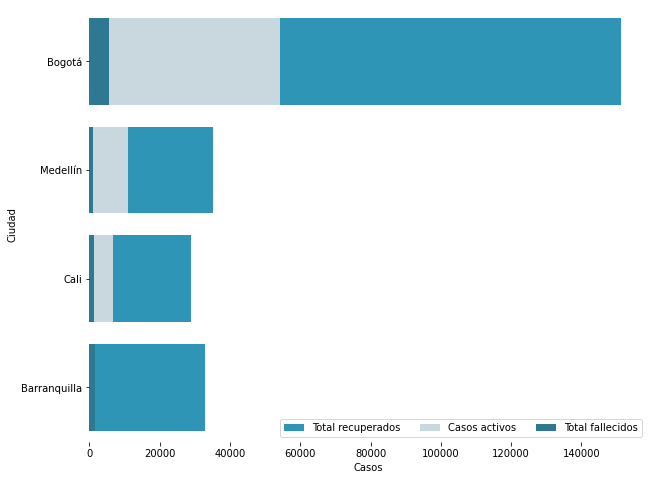

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
data = tot_casos_cids

data.sort_values('Activos', ascending=False, inplace=True)

#293550 #FFDD55A #6DD47E
#191979 #3D59AB #FF9912


# Recuperados
sns.set_color_codes("muted")
sns.barplot(x="Total recuperados", y="Ciudad", data=data, 
            label="Total recuperados", color="#18a1cd")

# Activos
sns.barplot(x="Activos", y="Ciudad", data=data, 
            label="Casos activos", color="#c5d8e3")

# Fallecidos
sns.barplot(x="Total fallecidos", y="Ciudad", data=data, 
            label="Total fallecidos", color="#1d81a2")

# Leyenda
ax.legend(ncol=3, loc='lower right', frameon=True)
ax.set(ylabel="Ciudad", xlabel="Casos")
sns.despine(left=True, bottom=True)

Reportados por día en cada una de las ciudades:

In [ ]:
# https://plot.ly/python/builtin-colorscales/

# Bogotá

fig = px.bar(df_bog_sum_cases, x='fecha', y="reportados", 
           color = "reportados", orientation="v", height=700, 
           title="Casos reportados en Bogotá", 
           color_discrete_sequence=px.colors.cyclical.Twilight,
           labels={
                     "fecha": "Fecha",
                     "reportados": "Casos reportados"
                 })

fig.update_layout(plot_bgcolor = 'rgb(220, 220, 220)')
fig.show()

In [ ]:
# Medellín

fig = px.bar(df_med_sum_cases, x='fecha', y="reportados", 
           color = "reportados", orientation="v", height=700, 
           title="Casos reportados en Medellín", 
           color_discrete_sequence=px.colors.cyclical.Twilight,
           labels={
                     "fecha": "Fecha",
                     "reportados": "Casos reportados"
                 })

fig.update_layout(plot_bgcolor = 'rgb(220, 220, 220)')
fig.show()

In [ ]:
# Cali

fig = px.bar(df_cal_sum_cases, x='fecha', y="reportados", 
           color = "reportados", orientation="v", height=700, 
           title="Casos reportados en Cali", 
           color_discrete_sequence=px.colors.cyclical.Twilight,
           labels={
                     "fecha": "Fecha",
                     "reportados": "Casos reportados"
                 })

fig.update_layout(plot_bgcolor = 'rgb(220, 220, 220)')
fig.show()

In [ ]:
# Barranquilla

fig = px.bar(df_bar_sum_cases, x='fecha', y="reportados", 
           color = "reportados", orientation="v", height=700, 
           title="Casos reportados en Barranquilla", 
           color_discrete_sequence=px.colors.cyclical.Twilight,
           labels={
                     "fecha": "Fecha",
                     "reportados": "Casos reportados"
                 })

fig.update_layout(plot_bgcolor = 'rgb(220, 220, 220)')
fig.show()

#3. Desarrollo del modelo

A partir de la elección de datos de interés y su respectivo proceso de limpieza se elige una librería de python llamada “Prophet”, la cual utiliza un modelo predictivo basado en series de tiempo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Este modelo fue elegido debido a que está basado en la evolución de los datos en el tiempo y según su documentación y los resultados que observamos durante el proceso es bastante robusto ante los datos faltantes y los cambios en las tendencias.

El modelo de series de tiempo que utliza “Prophet” tiene tres elementos, tendencia, estacionalidad y vacaciones, las cuales se combinan con las siguiente ecuación:



$y (t) = g (t) + s (t) + h (t) + εt $

Dónde:

* $g(t)$: curva de crecimiento lineal o logístico por partes para modelar cambios no periódicos en series de tiempo, la cual se representa con la siguiente manera

  $g(t)=\frac{C}{1+exp(-k(t-m))}$

  siendo: 

  1. $C$ la capacidad de carga.
  2. $k$ la tasa de crecimiento
  3. $m$ un parámetro de compensación

* $s(t)$: cambios periódicos (por ejemplo, estacionalidad semanal / anual). 

  Representado como

  $s(t)=\sum_{n=1}^{N}(a_ncos(\frac{2\pi nt}{P})+b_nsen(\frac{2\pi nt}{P}))$

  siendo

  1. $P$ es el periodo regular que tendrá la serie en días.
  2. $N$ es un parámetro de optimización con el que la serie será más óptima o no según el periodo en día. En general se ha encontrado que para la estacionalidad anual y semanal $N=10$ y $N=3$, respectivamente, funciona bien para la mayoría de problemas.


* $h(t)$ efectos de las vacaciones (proporcionado por el usuario) con horarios irregulares.

  Para utilizar esta función, el usuario debe proporcionar  una lista personalizada de eventos feriados correspondientes. La fusión de esta lista de vacaciones en el modelo simplifica suponiendo que los efectos de las vacaciones o días feriados son independientes.

  **Nota**:este parámetro no se utilizó en este ejercicio.

* $\epsilon t$ el término de error da cuenta de cualquier cambio inusual no acomodado por el modelo.

	Se refiere a la suma de la desviación estándar de los datos observados y la desviación estándar de los datos de la tendencia.













## 3.1 Predicciones Prophet: despliegue de resultados

Procederemos a realizar las predicciones, en este caso se harán predicciones tanto a corto, como a mediano plazo utilizando Prophet.

Se importan las librerías necesarias.

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

Se crea una función para realizar las predicciones. Se establece confianza en 95%.

In [ ]:
# Se crea una función para realizar las predicciones:

def predictor_ts(df_data, column_n, location, plazo, perds):
  
 

  # Filtrado y cambio de nombre de columnas
  data_d = df_data[['fecha', column_n]]
  data_d.columns = ["ds", "y"]


  # Instancia de Prohet y ajuste del modelo
  prop = Prophet(interval_width = 0.95)
  prop.fit(data_d)

  # Realización de predicciones
  d_pred = prop.make_future_dataframe(periods=perds) 
  d_prediction = prop.predict(d_pred)
  #print(d_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

  # Gráfica de predicciones
  d_prediction_plot = prop.plot(d_prediction, xlabel='Fecha', ylabel=column_n.title() )
  ax = d_prediction_plot.gca()
  ax.set_title('Predicción de '+column_n+' '+location+" a "+plazo, size=15)

  # Cálculo de errores
  metrics_df = d_prediction.set_index('ds')[['yhat']].join(data_d.set_index('ds').y).reset_index()
  metrics_df.dropna(inplace=True)
  rdos=r2_score(metrics_df.y, metrics_df.yhat)
  mse=mean_squared_error(metrics_df.y, metrics_df.yhat)
  mae=mean_absolute_error(metrics_df.y, metrics_df.yhat)
  

  print('La predicción de casos {0} de COVID en {1} para los próximos {2} días es:'.format(column_n, location, perds))
  print('El r2 es: ',rdos)
  print('El MSE es: ',mse)
  print('El MAE es: ',mae)

  return(d_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
         d_prediction_plot,
         rdos,
         mse,
         mae)

### 3.1.1 Predicciones a corto plazo

Se define el período de tiempo en el que se desea realizar predicciones, en este caso 15 días. Por lo tanto se harán predicciones entre las fechas 01-09-2020 y 15-09-2020. 

In [ ]:
perds = 15

#### 3.1.1.1 Colombia

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Colombia para los próximos 15 días es:
El r2 es:  0.9719099897635852
El MSE es:  91986797.07479498
El MAE es:  5710.737293872058


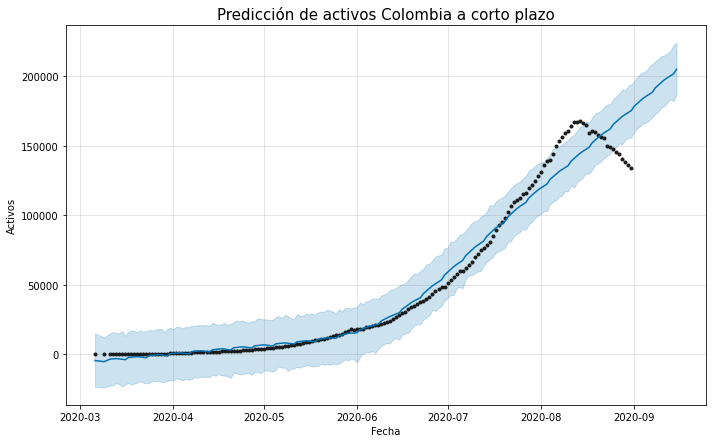

In [ ]:
# Activos
act_col_pred, act_col_plot, act_col_r2, act_col_mse, act_col_mae = predictor_ts(df_col_sum_cases, 'activos', "Colombia", "corto plazo", perds)

In [ ]:
act_col_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
176,2020-09-01,178590.112547,160144.175360,196895.748255
177,2020-09-02,180543.278150,162511.197020,199362.160761
178,2020-09-03,182422.827506,164348.486213,202028.269530
179,2020-09-04,184305.311084,166039.558318,202896.566114
180,2020-09-05,185789.619710,166775.662501,203895.632116
181,2020-09-06,187151.607516,168375.158236,207109.449612
182,2020-09-07,188551.143108,170604.134689,208782.071447
183,2020-09-08,191802.079709,173072.023588,210922.010141
184,2020-09-09,193755.245311,174685.628776,212685.637005
185,2020-09-10,195634.794668,177558.712785,214580.680955


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Colombia para los próximos 15 días es:
El r2 es:  0.9282372304427219
El MSE es:  1145334.5140696699
El MAE es:  685.0633641545083


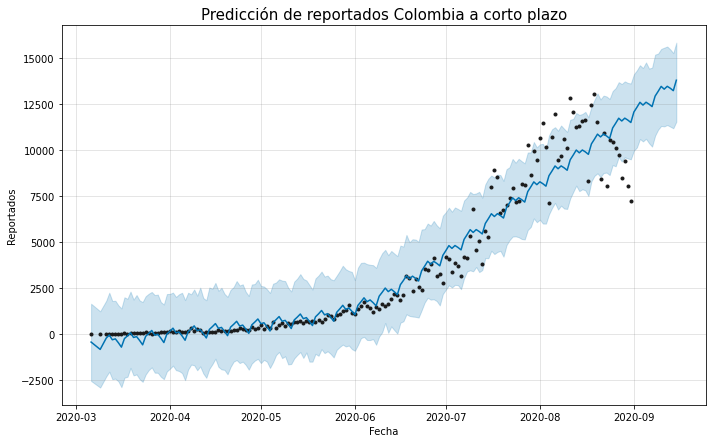

In [ ]:
# Reportados
rep_col_pred, rep_col_plot, rep_col_r2, rep_col_mse, rep_col_mae = predictor_ts(df_col_sum_cases, 'reportados', "Colombia",  "corto plazo", perds)

In [ ]:
rep_col_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
176,2020-09-01,12062.285323,9959.756112,14113.080171
177,2020-09-02,12319.650798,10139.110565,14329.411552
178,2020-09-03,12591.372859,10597.336572,14606.891429
179,2020-09-04,12440.460027,10464.279548,14453.367977
180,2020-09-05,12595.368057,10609.093650,14758.112388
181,2020-09-06,12489.987884,10368.283931,14426.208406
182,2020-09-07,12358.492512,10183.187359,14473.051256
183,2020-09-08,12927.759258,10777.818875,15182.747829
184,2020-09-09,13185.124733,11104.107333,15241.713065
185,2020-09-10,13456.846794,11307.996959,15492.374256


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Colombia para los próximos 15 días es:
El r2 es:  0.9463344559548457
El MSE es:  775795.720651313
El MAE es:  484.3610461848126


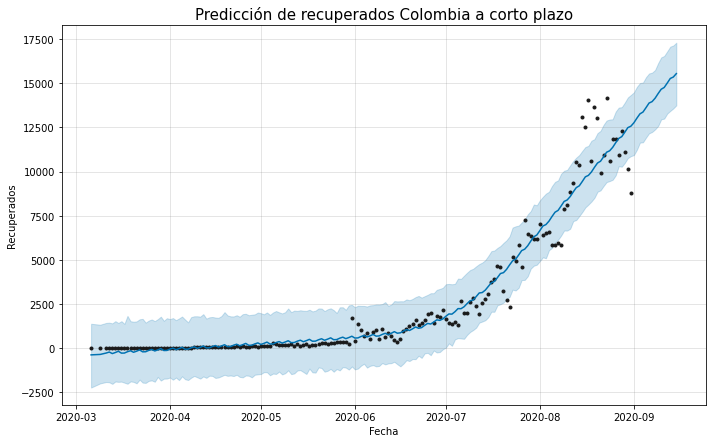

In [ ]:
# Recuperados
rec_col_pred, rec_col_plot, rec_col_r2, rec_col_mse, rec_col_mae = predictor_ts(df_col_sum_cases, 'recuperados', "Colombia",  "corto plazo", perds)

In [ ]:
rec_col_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
176,2020-09-01,12764.373082,10935.427039,14487.068882
177,2020-09-02,13027.821216,11238.072077,14798.234374
178,2020-09-03,13270.898397,11640.825120,15015.559115
179,2020-09-04,13372.888474,11661.654403,15043.677564
180,2020-09-05,13621.600600,11924.956650,15346.656397
181,2020-09-06,13881.802667,12167.958955,15556.428011
182,2020-09-07,13962.799412,12244.262381,15603.882812
183,2020-09-08,14156.516125,12394.295417,15754.126217
184,2020-09-09,14419.964259,12583.921819,16141.446953
185,2020-09-10,14663.041441,12960.578227,16465.344524


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Colombia para los próximos 15 días es:
El r2 es:  0.9735671305330856
El MSE es:  351.77100169381214
El MAE es:  12.25747357393023


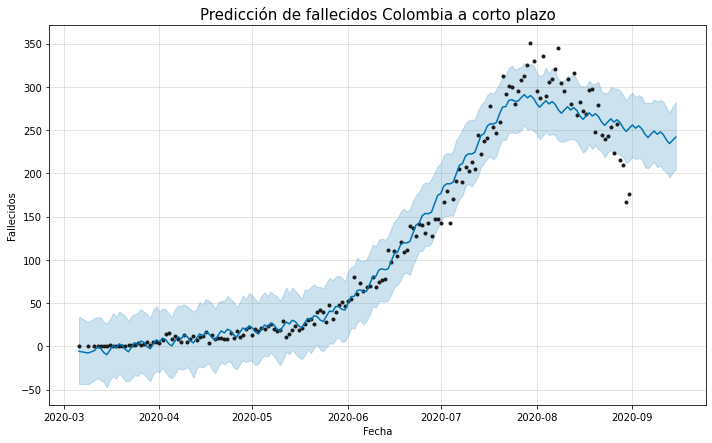

In [ ]:
# Fallecidos
fall_col_pred, fall_col_plot, fall_col_r2, fall_col_mse, fall_col_mae = predictor_ts(df_col_sum_cases, 'fallecidos', "Colombia",  "corto plazo", perds)

In [ ]:
fall_col_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
176,2020-09-01,255.871105,219.025001,293.002490
177,2020-09-02,252.075617,216.283545,287.875547
178,2020-09-03,254.844237,217.562757,290.275849
179,2020-09-04,251.582254,216.592624,288.363058
180,2020-09-05,245.362479,207.218795,281.176756
181,2020-09-06,241.323484,205.733666,281.697817
182,2020-09-07,245.243775,209.621863,281.267497
183,2020-09-08,248.858318,212.834030,285.290770
184,2020-09-09,245.062830,207.044268,282.905653
185,2020-09-10,247.831450,208.976699,284.642589


####3.1.1.2 Bogotá

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Bogotá D.C. para los próximos 15 días es:
El r2 es:  0.9710949368252257
El MSE es:  15855756.236705396
El MAE es:  2344.3526509170547


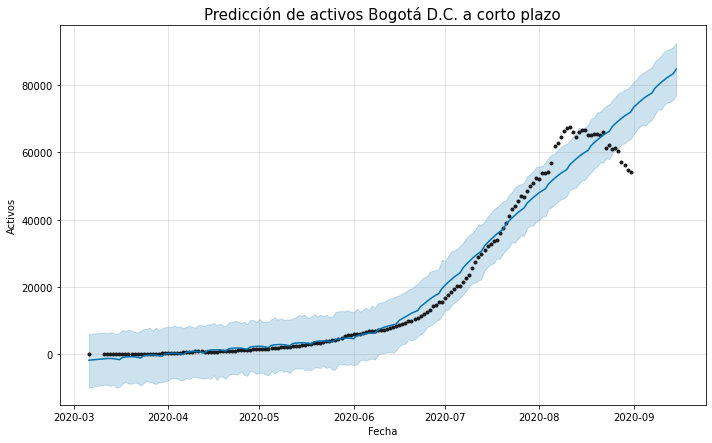

In [ ]:
# Activos
act_bog_pred, act_bog_plot, act_bog_r2, act_bog_mse, act_bog_mae = predictor_ts(df_bog_sum_cases, 'activos', "Bogotá D.C.", "corto plazo",perds)

In [ ]:
act_bog_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
175,2020-09-01,73368.728336,65328.733941,80966.630906
176,2020-09-02,74238.387679,66633.207858,81657.982584
177,2020-09-03,75056.018547,67646.026455,82905.018511
178,2020-09-04,75804.745757,68232.295676,83558.396471
179,2020-09-05,76514.801189,68002.641304,84167.813459
180,2020-09-06,77097.980179,69047.651253,84743.880798
181,2020-09-07,77646.065791,69695.068182,85310.894778
182,2020-09-08,79060.336592,71335.097108,87052.945774
183,2020-09-09,79929.995935,72804.476444,87749.075845
184,2020-09-10,80747.626803,72681.708356,88712.902426


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Bogotá D.C. para los próximos 15 días es:
El r2 es:  0.8328191900368545
El MSE es:  359770.4793855775
El MAE es:  375.0268592551857


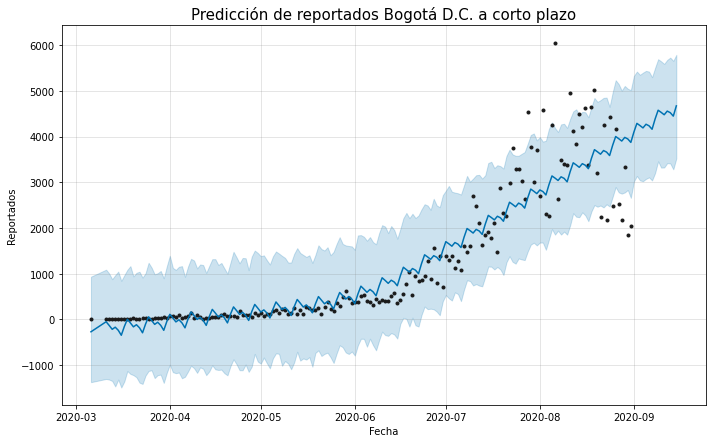

In [ ]:
# Reportados
rep_bog_pred, rep_bog_plot, rep_bog_r2, rep_bog_mse, rep_bog_mae = predictor_ts(df_bog_sum_cases, 'reportados', "Bogotá D.C.", "corto plazo", perds)

In [ ]:
rep_bog_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
175,2020-09-01,4097.618415,3017.440060,5326.825576
176,2020-09-02,4289.776014,3139.594283,5422.865792
177,2020-09-03,4242.585813,3043.097029,5352.106903
178,2020-09-04,4190.689659,3024.649688,5398.780740
179,2020-09-05,4270.586628,3075.212401,5438.417302
180,2020-09-06,4236.341380,3109.047068,5421.732296
181,2020-09-07,4160.694027,3041.362795,5300.278779
182,2020-09-08,4385.183781,3203.576001,5504.710333
183,2020-09-09,4577.341380,3460.135060,5694.062087
184,2020-09-10,4530.151179,3321.949853,5646.455682


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Bogotá D.C. para los próximos 15 días es:
El r2 es:  0.8447423504505474
El MSE es:  299860.7615092134
El MAE es:  278.2638260039014


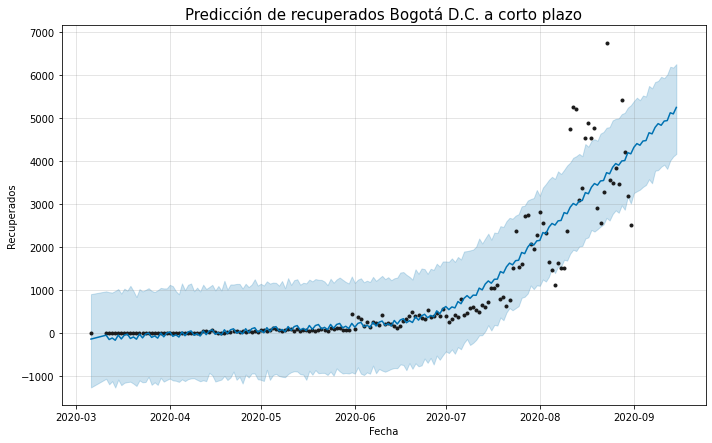

In [ ]:
# Recuperados
rec_bog_pred, rec_bog_plot, rec_bog_r2, rec_bog_mse, rec_bog_mae = predictor_ts(df_bog_sum_cases, 'recuperados', "Bogotá D.C.", "corto plazo", perds)

In [ ]:
rec_bog_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
175,2020-09-01,4328.007870,3265.236306,5402.600914
176,2020-09-02,4414.642703,3305.853493,5482.598526
177,2020-09-03,4376.540470,3343.604115,5424.291756
178,2020-09-04,4474.687685,3406.670864,5533.527295
179,2020-09-05,4485.273022,3453.911007,5510.700854
180,2020-09-06,4667.514635,3584.996250,5756.242412
181,2020-09-07,4641.572953,3492.395695,5700.140406
182,2020-09-08,4792.324115,3783.449573,5846.154260
183,2020-09-09,4878.958948,3798.777013,5872.379119
184,2020-09-10,4840.856715,3875.627354,5968.605436


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Bogotá D.C. para los próximos 15 días es:
El r2 es:  0.7847716198972381
El MSE es:  297.6768802432632
El MAE es:  12.68601409991789


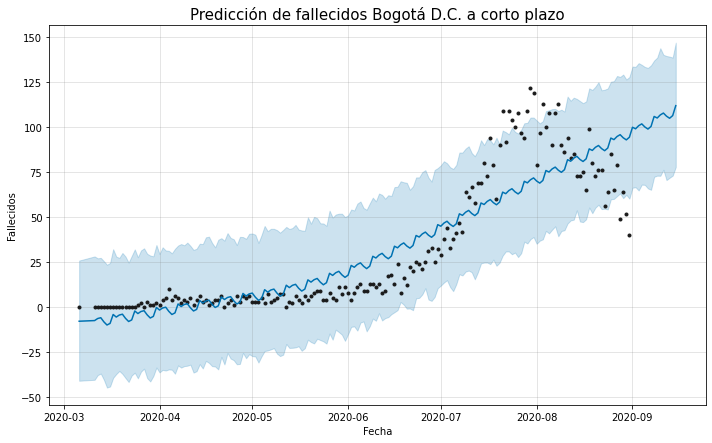

In [ ]:
# Fallecidos
fall_bog_pred, fall_bog_plot, fall_bog_r2, fall_bog_mse, fall_bog_mae = predictor_ts(df_bog_sum_cases, 'fallecidos', "Bogotá D.C.", "corto plazo", perds)

In [ ]:
fall_bog_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
175,2020-09-01,100.030962,66.371831,133.835673
176,2020-09-02,99.176668,66.664074,133.658534
177,2020-09-03,100.899395,64.842519,135.724341
178,2020-09-04,101.924710,68.100291,134.777836
179,2020-09-05,100.194069,67.981359,133.614915
180,2020-09-06,99.027938,65.999468,133.068449
181,2020-09-07,100.499601,65.224467,134.548505
182,2020-09-08,106.047478,72.450581,137.190788
183,2020-09-09,105.193184,73.095552,138.819417
184,2020-09-10,106.915911,73.023439,144.032029


####3.1.1.3 Medellín

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Medellín para los próximos 15 días es:
El r2 es:  0.881399005661637
El MSE es:  3582695.563007367
El MAE es:  1251.6344134086687


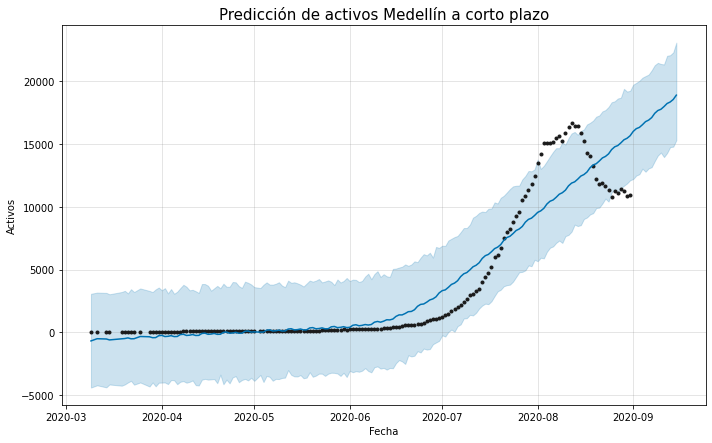

In [ ]:
# Activos
act_med_pred, act_med_plot, act_med_r2, act_med_mse, act_med_mae = predictor_ts(df_med_sum_cases, 'activos', "Medellín", "corto plazo", perds)

In [ ]:
act_med_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
166,2020-09-01,16011.884766,12219.693581,19734.928244
167,2020-09-02,16232.012260,12496.606724,19881.792470
168,2020-09-03,16332.448936,12603.958380,20044.789118
169,2020-09-04,16546.586242,13044.425562,20293.253088
170,2020-09-05,16791.263989,12799.881781,20421.493605
171,2020-09-06,16911.790820,13063.382824,20540.410982
172,2020-09-07,17113.835731,13167.265404,20879.221028
173,2020-09-08,17457.576713,13649.144357,21291.447525
174,2020-09-09,17677.704206,14090.838763,21477.526572
175,2020-09-10,17778.140883,14325.671972,21387.944948


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Medellín para los próximos 15 días es:
El r2 es:  0.7809284581470552
El MSE es:  37071.91672736671
El MAE es:  119.34470816090001


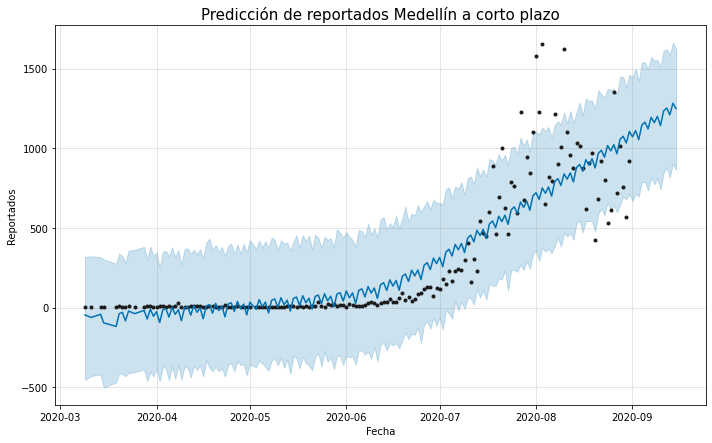

In [ ]:
# Reportados
rep_med_pred, rep_med_plot, rep_med_r2, rep_med_mse, rep_med_mae = predictor_ts(df_med_sum_cases, 'reportados', "Medellín", "corto plazo", perds)

In [ ]:
rep_med_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
166,2020-09-01,1071.763880,669.066919,1446.178215
167,2020-09-02,1111.326578,716.255991,1498.909585
168,2020-09-03,1053.961776,695.437357,1420.518432
169,2020-09-04,1144.981416,785.726208,1539.047304
170,2020-09-05,1163.975601,790.379615,1537.554491
171,2020-09-06,1121.251883,735.347495,1494.884141
172,2020-09-07,1193.910808,818.157767,1572.636204
173,2020-09-08,1160.368445,773.082490,1552.193154
174,2020-09-09,1199.931143,810.782107,1553.904147
175,2020-09-10,1142.566341,741.985526,1512.170617


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Medellín para los próximos 15 días es:
El r2 es:  0.8350027930753764
El MSE es:  25706.08031973213
El MAE es:  81.16595456905746


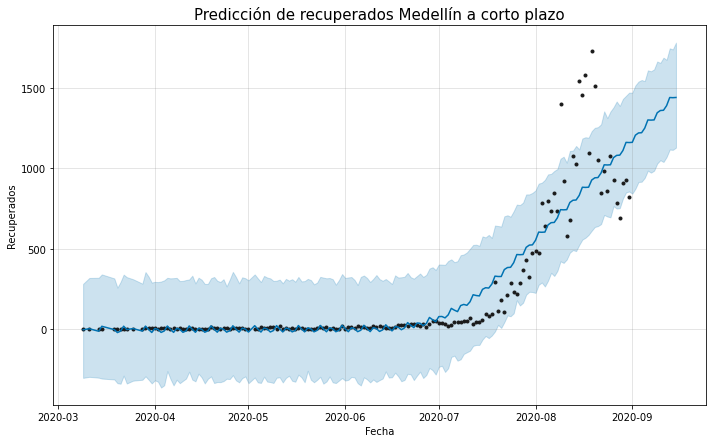

In [ ]:
# Recuperados
rec_med_pred, rec_med_plot, rec_med_r2, rec_med_mse, rec_med_mae = predictor_ts(df_med_sum_cases, 'recuperados', "Medellín", "corto plazo", perds)

In [ ]:
rec_med_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
166,2020-09-01,1162.014302,843.011537,1470.920339
167,2020-09-02,1206.608644,873.192802,1515.895851
168,2020-09-03,1220.484144,915.381617,1540.065792
169,2020-09-04,1221.968815,917.072662,1549.675417
170,2020-09-05,1250.622834,941.072842,1543.001289
171,2020-09-06,1301.348484,985.976986,1609.791206
172,2020-09-07,1300.321213,973.278414,1604.149140
173,2020-09-08,1301.562658,985.693688,1616.079927
174,2020-09-09,1346.157000,1030.239906,1664.868341
175,2020-09-10,1360.032500,1050.968302,1656.140609


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Medellín para los próximos 15 días es:
El r2 es:  0.8409057851227898
El MSE es:  11.741425566536686
El MAE es:  2.073849368403279


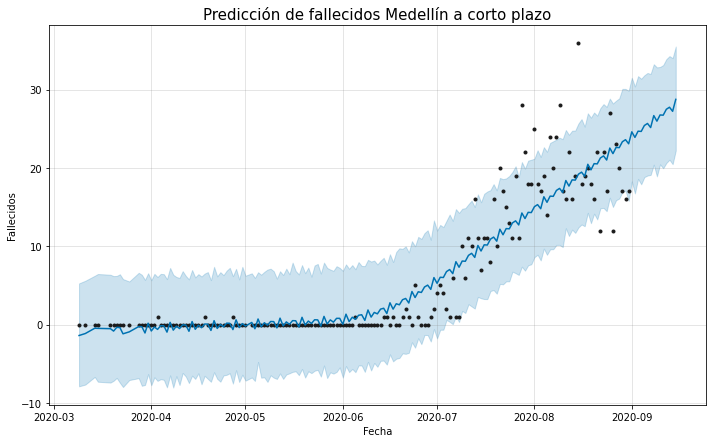

In [ ]:
# Fallecidos
fall_med_pred, fall_med_plot, fall_med_r2, fall_med_mse, fall_med_mae = predictor_ts(df_med_sum_cases, 'fallecidos', "Medellín", "corto plazo",  perds)

In [ ]:
fall_med_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
166,2020-09-01,24.611713,18.278261,31.517436
167,2020-09-02,23.899810,16.747465,30.402126
168,2020-09-03,24.693202,18.602499,31.722587
169,2020-09-04,24.664437,17.912652,31.390230
170,2020-09-05,25.417606,18.832021,31.832470
171,2020-09-06,25.681015,19.029027,32.127182
172,2020-09-07,25.158829,19.110107,32.001121
173,2020-09-08,26.684506,20.412938,33.242981
174,2020-09-09,25.972604,18.924189,32.844024
175,2020-09-10,26.765995,20.455858,32.894090


####3.1.1.4 Cali

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Cali para los próximos 15 días es:
El r2 es:  0.9602475819179361
El MSE es:  418374.8874318951
El MAE es:  346.5867992351487


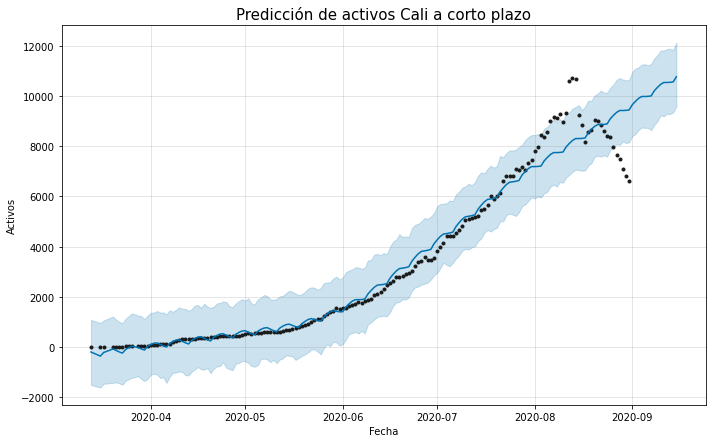

In [ ]:
# Activos
act_cal_pred, act_cal_plot, act_cal_r2, act_cal_mse, act_cal_mae = predictor_ts(df_cal_sum_cases, 'activos', "Cali", "corto plazo", perds)


In [ ]:
act_cal_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
167,2020-09-01,9651.651675,8407.714659,10970.691567
168,2020-09-02,9789.060161,8484.105067,11085.674424
169,2020-09-03,9906.667659,8653.047744,11143.125502
170,2020-09-04,9983.161526,8748.879403,11252.038939
171,2020-09-05,9983.586777,8735.033441,11271.276725
172,2020-09-06,9988.740900,8731.764463,11221.991193
173,2020-09-07,10005.750764,8641.856389,11276.557455
174,2020-09-08,10210.197293,8852.884567,11504.212770
175,2020-09-09,10347.605779,9005.345699,11629.702492
176,2020-09-10,10465.213277,9234.540752,11811.999799


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Cali para los próximos 15 días es:
El r2 es:  0.6940630173912306
El MSE es:  19531.74330268846
El MAE es:  84.64644357202609


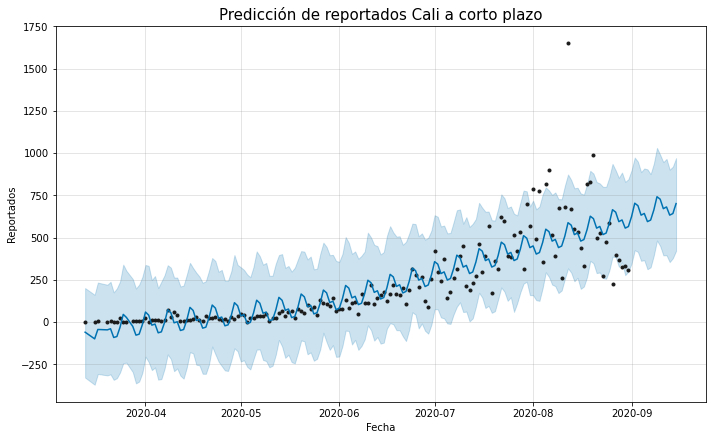

In [ ]:
# Reportados
rep_cal_pred, rep_cal_plot, rep_cal_r2, rep_cal_mse, rep_cal_mae = predictor_ts(df_cal_sum_cases, 'reportados', "Cali", "corto plazo", perds)

In [ ]:
rep_cal_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
167,2020-09-01,625.157018,348.103919,899.692191
168,2020-09-02,704.250020,426.384172,974.282386
169,2020-09-03,689.598448,415.906734,949.899468
170,2020-09-04,633.522618,363.494857,887.992976
171,2020-09-05,643.631707,367.233565,909.664486
172,2020-09-06,595.376349,313.560252,904.506958
173,2020-09-07,604.572456,325.120289,875.985998
174,2020-09-08,663.573875,395.328549,938.138350
175,2020-09-09,742.666878,483.468536,1031.597110
176,2020-09-10,728.015306,451.178610,990.659806


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Cali para los próximos 15 días es:
El r2 es:  0.7533586330660389
El MSE es:  15667.994492571344
El MAE es:  52.08976236690379


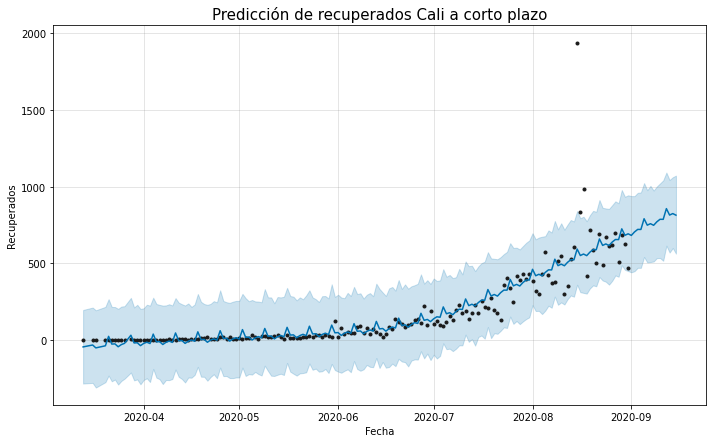

In [ ]:
# Recuperados
rec_cal_pred, rec_cal_plot, rec_cal_r2, rec_cal_mse, rec_cal_mae = predictor_ts(df_cal_sum_cases, 'recuperados', "Cali", "corto plazo", perds)

In [ ]:
rec_cal_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
167,2020-09-01,682.801552,441.992369,939.138094
168,2020-09-02,705.383382,449.450864,939.027771
169,2020-09-03,721.947546,471.400595,960.441719
170,2020-09-04,721.635331,471.357012,963.305055
171,2020-09-05,791.575543,542.355875,1024.033172
172,2020-09-06,749.561907,506.525455,977.450295
173,2020-09-07,759.235494,509.116838,1005.933229
174,2020-09-08,748.773949,512.634539,975.594294
175,2020-09-09,771.355779,534.582272,1001.890733
176,2020-09-10,787.919943,535.387265,1021.746347


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Cali para los próximos 15 días es:
El r2 es:  0.7306317094370409
El MSE es:  15.610283127906305
El MAE es:  2.958193367006446


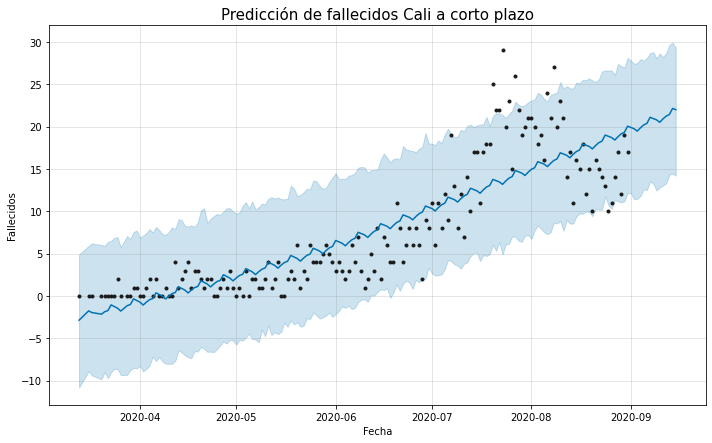

In [ ]:
# Fallecidos
fall_cal_pred, fall_cal_plot, fall_cal_r2, fall_cal_mse, fall_cal_mae = predictor_ts(df_cal_sum_cases, 'fallecidos', "Cali", "corto plazo", perds)

In [ ]:
fall_cal_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
167,2020-09-01,19.905974,12.117590,27.810090
168,2020-09-02,19.752223,11.411866,27.419738
169,2020-09-03,19.463931,11.481224,27.503152
170,2020-09-04,19.856509,11.801526,27.973805
171,2020-09-05,20.192095,12.592603,27.785740
172,2020-09-06,20.378120,12.515952,28.106511
173,2020-09-07,21.096296,13.520956,28.674309
174,2020-09-08,20.953092,13.254560,28.790286
175,2020-09-09,20.799341,12.440209,28.056844
176,2020-09-10,20.511049,12.801621,28.645217


#### 3.1.1.5 Barranquilla

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Barranquilla para los próximos 15 días es:
El r2 es:  0.9899552751663842
El MSE es:  104064.97680066028
El MAE es:  208.01469537750432


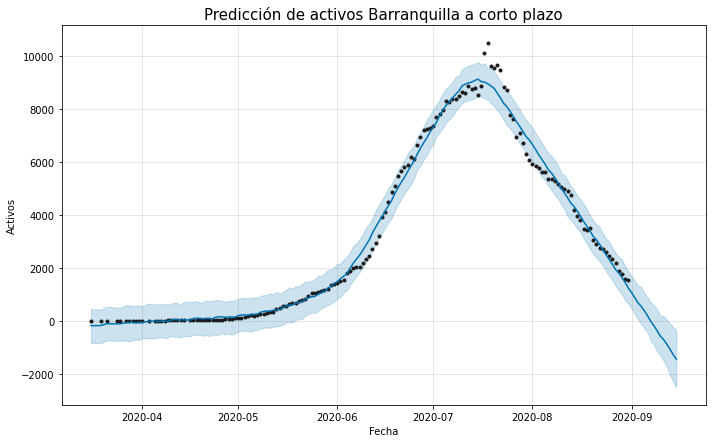

In [ ]:
# Activos
act_bar_pred, act_bar_plot, act_bar_r2, act_bar_mse, act_bar_mae = predictor_ts(df_bar_sum_cases, 'activos', "Barranquilla", "corto plazo", perds)

In [ ]:
act_bar_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
160,2020-09-01,1089.863023,495.102642,1725.170982
161,2020-09-02,902.205754,275.395736,1535.613285
162,2020-09-03,702.432974,71.305627,1374.275843
163,2020-09-04,573.230830,-95.079643,1292.390578
164,2020-09-05,401.364494,-251.412401,1069.554864
165,2020-09-06,212.057407,-428.689961,920.107418
166,2020-09-07,6.339858,-712.417486,715.628725
167,2020-09-08,-165.164569,-893.474055,604.073789
168,2020-09-09,-352.821838,-1120.999529,452.908663
169,2020-09-10,-552.594618,-1295.090432,228.679965


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Barranquilla para los próximos 15 días es:
El r2 es:  0.5058513568473888
El MSE es:  37342.351069180244
El MAE es:  111.59432984284929


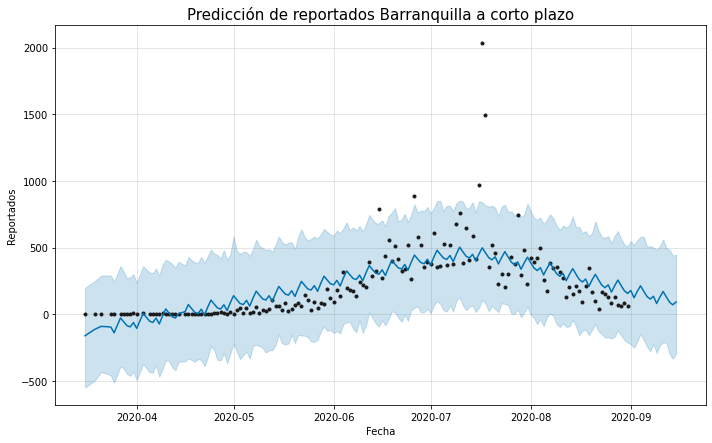

In [ ]:
# Reportados
rep_bar_pred, rep_bar_plot, rep_bar_r2, rep_bar_mse, rep_bar_mae = predictor_ts(df_bar_sum_cases, 'reportados', "Barranquilla", "corto plazo", perds)

In [ ]:
rep_bar_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
160,2020-09-01,177.765996,-225.433517,549.746941
161,2020-09-02,123.238433,-250.948986,519.096259
162,2020-09-03,171.399356,-204.134317,555.286724
163,2020-09-04,213.436336,-146.655483,580.948283
164,2020-09-05,172.236237,-196.193920,582.015201
165,2020-09-06,133.222365,-241.495395,506.317561
166,2020-09-07,113.306460,-279.183971,510.778025
167,2020-09-08,134.892183,-223.389609,500.873918
168,2020-09-09,80.364620,-291.706979,483.785631
169,2020-09-10,128.525543,-232.260562,511.355178


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Barranquilla para los próximos 15 días es:
El r2 es:  0.47943068219875606
El MSE es:  35945.225154547894
El MAE es:  128.6652599332637


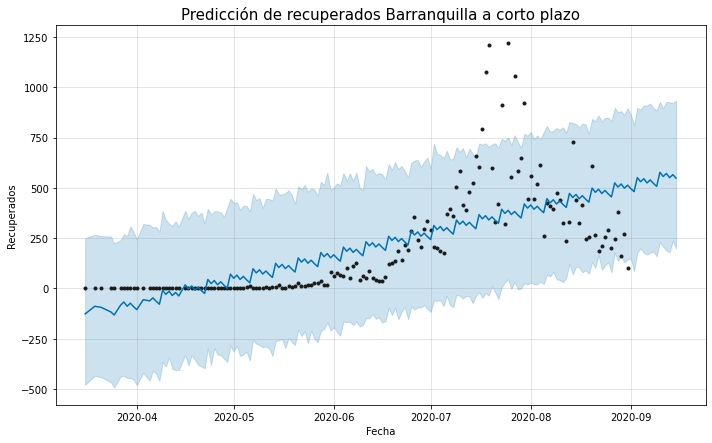

In [ ]:
# Recuperados
rec_bar_pred, rec_bar_plot, rec_bar_r2, rec_bar_mse, rec_bar_mae = predictor_ts(df_bar_sum_cases, 'recuperados', "Barranquilla", "corto plazo", perds)

In [ ]:
rec_bar_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
160,2020-09-01,495.975550,148.287067,863.645075
161,2020-09-02,481.131157,86.345321,812.933438
162,2020-09-03,551.068929,178.307766,898.541521
163,2020-09-04,530.299274,199.947422,889.379024
164,2020-09-05,545.534371,177.080655,909.290513
165,2020-09-06,524.493521,167.394088,909.624002
166,2020-09-07,539.350041,177.666268,919.086417
167,2020-09-08,522.141900,183.726804,896.381303
168,2020-09-09,507.297506,159.763966,885.217724
169,2020-09-10,577.235279,230.124785,927.096195


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Barranquilla para los próximos 15 días es:
El r2 es:  0.6762477088955801
El MSE es:  46.64036209204856
El MAE es:  5.459478963265513


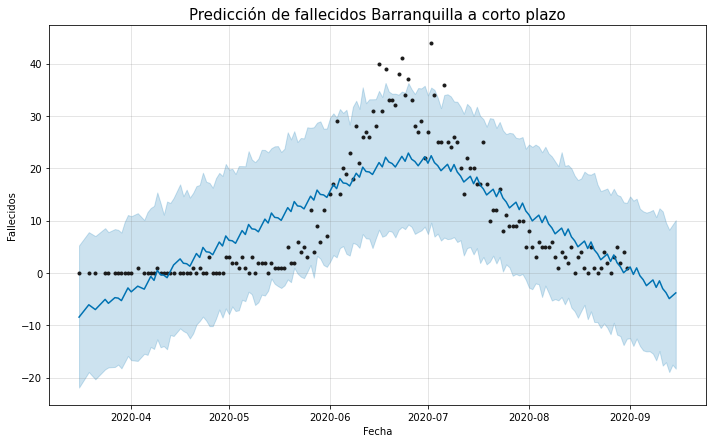

In [ ]:
# Fallecidos
fall_bar_pred, fall_bar_plot, fall_bar_r2, fall_bar_mse, fall_bar_mae = predictor_ts(df_bar_sum_cases, 'fallecidos', "Barranquilla", "corto plazo", perds)

In [ ]:
fall_bar_pred.tail(15)

,ds,yhat,yhat_lower,yhat_upper
160,2020-09-01,1.147529,-12.463398,14.632554
161,2020-09-02,-0.271259,-13.940485,13.822567
162,2020-09-03,0.976263,-12.517679,14.178932
163,2020-09-04,-0.518675,-13.926887,12.282113
164,2020-09-05,-1.278042,-14.788305,11.774332
165,2020-09-06,-2.421390,-14.980662,11.530634
166,2020-09-07,-1.861281,-14.950355,11.716260
167,2020-09-08,-1.327841,-15.412242,12.044491
168,2020-09-09,-2.746629,-16.684371,10.660084
169,2020-09-10,-1.499107,-14.894233,12.354461


###3.1.2 Predicciones a mediano plazo

Se define el período de tiempo en el que se desea realizar predicciones, en este caso 92 días. Por lo tanto se harán predicciones entre las fechas 01-09-2020 y 29-11-2020. 

In [ ]:
perds = 90

####3.1.2.1 Colombia

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Colombia para los próximos 90 días es:
El r2 es:  0.9719099897635852
El MSE es:  91986797.07479498
El MAE es:  5710.737293872058


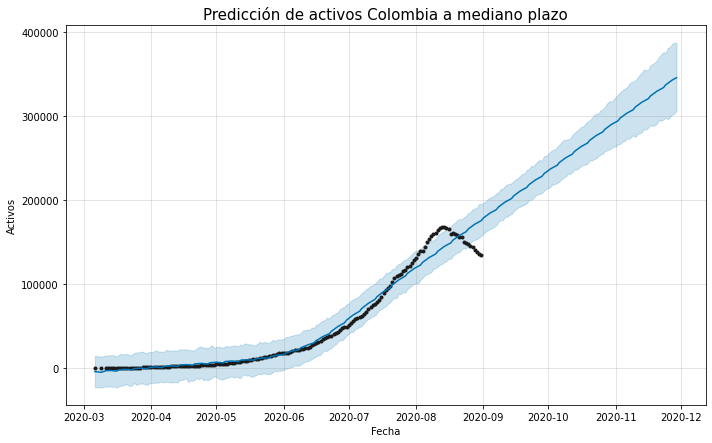

In [ ]:
# Activos
act_col_pred_medplaz, act_col_plot_medplaz, act_col_r2_medplaz, act_col_mse_medplaz, act_col_mae_medplaz = predictor_ts(df_col_sum_cases, 'activos', "Colombia", "mediano plazo", perds)

In [ ]:
act_col_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
256,2020-11-20,329636.949860,291247.075515,366513.688776
257,2020-11-21,331121.258486,295312.632312,370463.647769
258,2020-11-22,332483.246292,294404.113970,373479.906837
259,2020-11-23,333882.781884,295835.631384,376163.506386
260,2020-11-24,337133.718485,298389.983511,375245.217494
261,2020-11-25,339086.884087,296197.324887,380980.230921
262,2020-11-26,340966.433444,298882.352171,382303.935680
263,2020-11-27,342848.917022,301826.721219,386002.448732
264,2020-11-28,344333.225647,303058.266953,387427.555694
265,2020-11-29,345695.213453,306334.394768,386957.877601


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Colombia para los próximos 90 días es:
El r2 es:  0.9282372304427219
El MSE es:  1145334.5140696699
El MAE es:  685.0633641545083


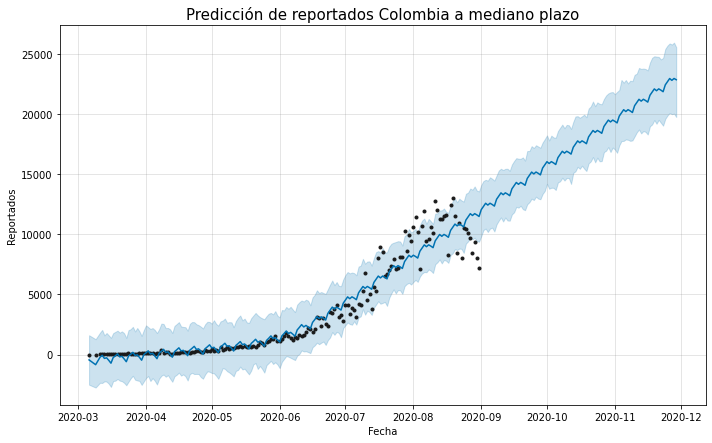

In [ ]:
# Reportados
rep_col_pred_medplaz, rep_col_plot_medplaz, rep_col_r2_medplaz, rep_col_mse_medplaz, rep_col_mae_medplaz = predictor_ts(df_col_sum_cases, 'reportados', "Colombia",  "mediano plazo", perds)

In [ ]:
rep_col_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
256,2020-11-20,21960.673312,19210.560517,24799.424234
257,2020-11-21,22115.581342,19538.988274,24776.149865
258,2020-11-22,22010.201169,19290.661821,24571.422705
259,2020-11-23,21878.705797,19052.559393,24683.911630
260,2020-11-24,22447.972543,19620.158292,25439.547312
261,2020-11-25,22705.338018,19901.307381,25716.505763
262,2020-11-26,22977.060079,20108.486240,25899.013334
263,2020-11-27,22826.147247,20006.412785,25803.673616
264,2020-11-28,22981.055277,20054.690013,25963.363686
265,2020-11-29,22875.675104,19771.576641,25581.319172


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Colombia para los próximos 90 días es:
El r2 es:  0.9463344559548457
El MSE es:  775795.720651313
El MAE es:  484.3610461848126


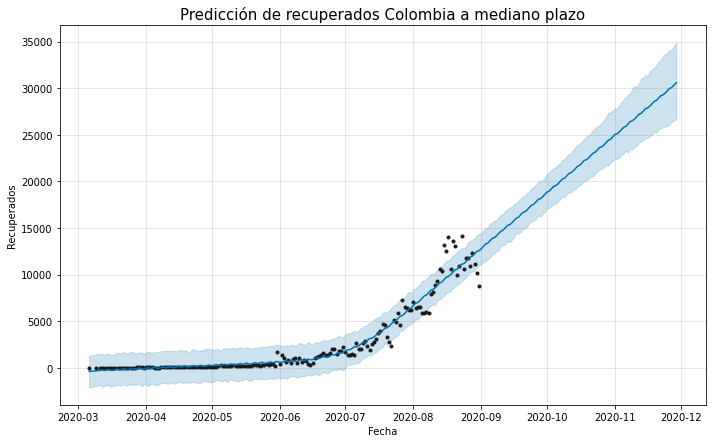

In [ ]:
# Recuperados
rec_col_pred_medplaz, rec_col_plot_medplaz, rec_col_r2_medplaz, rec_col_mse_medplaz, rec_col_mae_medplaz = predictor_ts(df_col_sum_cases, 'recuperados', "Colombia",  "mediano plazo", perds)

In [ ]:
rec_col_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
256,2020-11-20,28686.461952,25200.149110,32446.537489
257,2020-11-21,28935.174078,25679.138829,32838.418624
258,2020-11-22,29195.376146,25656.046944,33027.788769
259,2020-11-23,29276.372891,25818.490899,33455.376235
260,2020-11-24,29470.089603,25882.476075,33638.050510
261,2020-11-25,29733.537738,25908.134106,33813.209599
262,2020-11-26,29976.614919,26136.327303,34074.362285
263,2020-11-27,30078.604996,26381.450163,34135.046631
264,2020-11-28,30327.317121,26532.222949,34517.627069
265,2020-11-29,30587.519189,26662.783847,34877.796132


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Colombia para los próximos 90 días es:
El r2 es:  0.9735671305330856
El MSE es:  351.77100169381214
El MAE es:  12.25747357393023


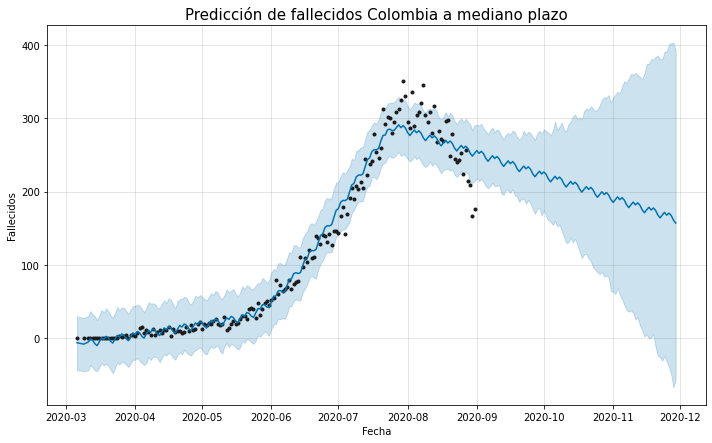

In [ ]:
# Fallecidos
fall_col_pred_medplaz, fall_col_plot_medplaz, fall_col_r2_medplaz, fall_col_mse_medplaz, fall_col_mae_medplaz = predictor_ts(df_col_sum_cases, 'fallecidos', "Colombia",  "mediano plazo", perds)

In [ ]:
fall_col_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
256,2020-11-20,174.441597,-11.883550,383.481906
257,2020-11-21,168.221823,-23.411279,385.218369
258,2020-11-22,164.182828,-25.536423,380.337284
259,2020-11-23,168.103118,-30.265351,380.279314
260,2020-11-24,171.717661,-23.616279,390.320001
261,2020-11-25,167.922174,-31.170045,391.145629
262,2020-11-26,170.690793,-38.586648,400.660523
263,2020-11-27,167.428810,-49.406827,402.380457
264,2020-11-28,161.209036,-66.899737,402.881654
265,2020-11-29,157.170041,-55.307009,392.601502


####3.1.2.2 Bogotá

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Bogotá D.C. para los próximos 90 días es:
El r2 es:  0.9710949368252257
El MSE es:  15855756.236705396
El MAE es:  2344.3526509170547


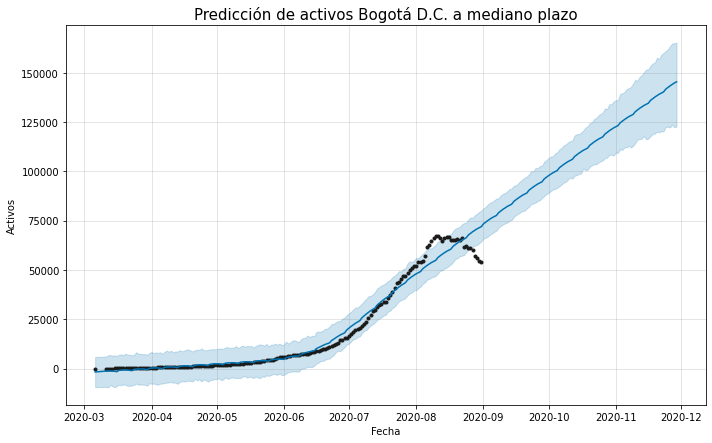

In [ ]:
# Activos
act_bog_pred_medplaz, act_bog_plot_medplaz, act_bog_r2_medplaz, act_bog_mse_medplaz, act_bog_mae_medplaz = predictor_ts(df_bog_sum_cases, 'activos', "Bogotá D.C.", "mediano plazo",perds)

In [ ]:
act_bog_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
255,2020-11-20,138412.436577,120122.851417,157659.172475
256,2020-11-21,139122.492009,119769.390806,156962.006030
257,2020-11-22,139705.670999,120367.468982,159171.807878
258,2020-11-23,140253.756612,120273.224868,160062.907222
259,2020-11-24,141668.027413,122501.993677,161058.256790
260,2020-11-25,142537.686756,122612.201275,161871.123065
261,2020-11-26,143355.317623,122262.537859,163450.640397
262,2020-11-27,144104.044833,123730.259507,164871.493231
263,2020-11-28,144814.100265,122311.817075,164937.908312
264,2020-11-29,145397.279255,122780.928946,165273.077209


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Bogotá D.C. para los próximos 90 días es:
El r2 es:  0.8328191900368545
El MSE es:  359770.4793855775
El MAE es:  375.0268592551857


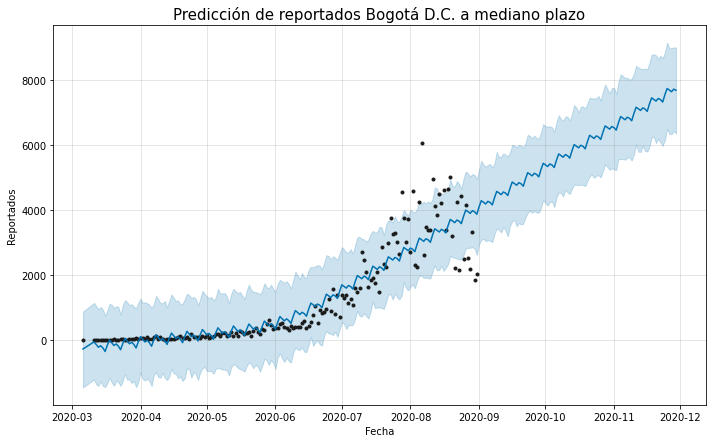

In [ ]:
# Reportados
rep_bog_pred_medplaz, rep_bog_plot_medplaz, rep_bog_r2_medplaz, rep_bog_mse_medplaz, rep_bog_mae_medplaz = predictor_ts(df_bog_sum_cases, 'reportados', "Bogotá D.C.", "mediano plazo", perds)

In [ ]:
rep_bog_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
255,2020-11-20,7353.908690,6061.521523,8758.949927
256,2020-11-21,7433.805659,6201.709110,8654.263767
257,2020-11-22,7399.560411,6075.128649,8747.981489
258,2020-11-23,7323.913058,5975.843495,8676.346639
259,2020-11-24,7548.402812,6160.694519,8843.525845
260,2020-11-25,7740.560411,6504.851381,9151.200972
261,2020-11-26,7693.370210,6343.793937,8976.080285
262,2020-11-27,7641.474057,6337.670526,8982.887419
263,2020-11-28,7721.371026,6438.560170,9004.336231
264,2020-11-29,7687.125777,6359.114669,9005.697988


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Bogotá D.C. para los próximos 90 días es:
El r2 es:  0.8447423504505474
El MSE es:  299860.7615092134
El MAE es:  278.2638260039014


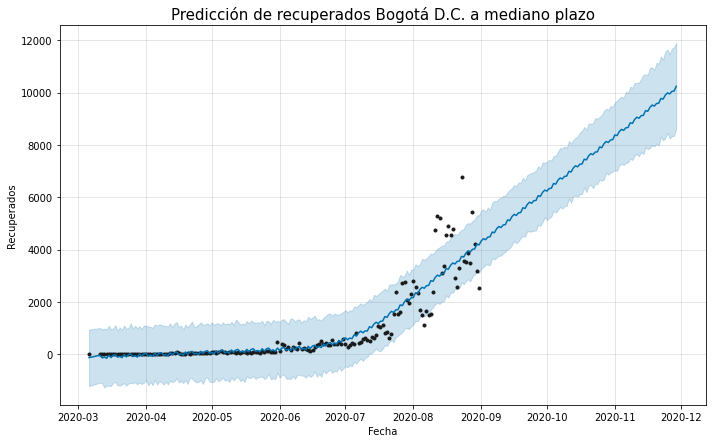

In [ ]:
# Recuperados
rec_bog_pred_medplaz, rec_bog_plot_medplaz, rec_bog_r2_medplaz, rec_bog_mse_medplaz, rec_bog_mae_medplaz = predictor_ts(df_bog_sum_cases, 'recuperados', "Bogotá D.C.", "mediano plazo", perds)

In [ ]:
rec_bog_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
255,2020-11-20,9582.166380,8045.992837,11139.846084
256,2020-11-21,9592.751716,7981.877142,11103.711874
257,2020-11-22,9774.993329,8319.506787,11382.607531
258,2020-11-23,9749.051647,8172.828819,11257.288239
259,2020-11-24,9899.802809,8260.463872,11568.094545
260,2020-11-25,9986.437642,8459.625613,11641.060301
261,2020-11-26,9948.335409,8236.727483,11474.632459
262,2020-11-27,10046.482625,8333.380242,11680.962031
263,2020-11-28,10057.067961,8343.931422,11725.519624
264,2020-11-29,10239.309574,8611.756151,11908.210792


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Bogotá D.C. para los próximos 90 días es:
El r2 es:  0.7847716198972381
El MSE es:  297.6768802432632
El MAE es:  12.68601409991789


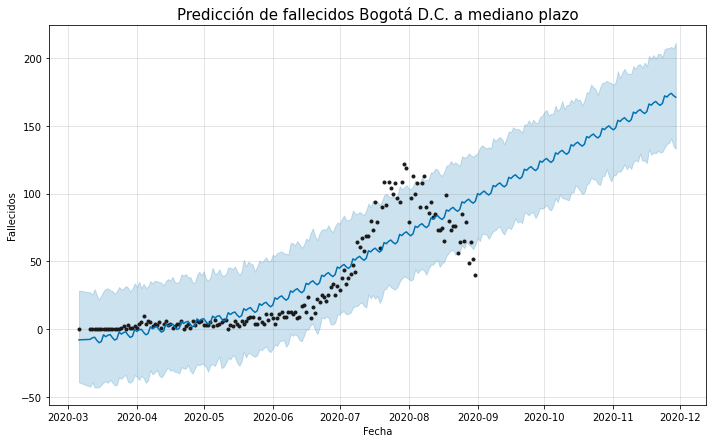

In [ ]:
# Fallecidos
fall_bog_pred_medplaz, fall_bog_plot_medplaz, fall_bog_r2_medplaz, fall_bog_mse_medplaz, fall_bog_mae_medplaz = predictor_ts(df_bog_sum_cases, 'fallecidos', "Bogotá D.C.", "mediano plazo", perds)

In [ ]:
fall_bog_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
255,2020-11-20,168.106385,129.892910,199.640084
256,2020-11-21,166.375744,131.629518,203.127790
257,2020-11-22,165.209613,130.419396,203.219327
258,2020-11-23,166.681276,130.875990,200.747479
259,2020-11-24,172.229153,134.083703,206.633210
260,2020-11-25,171.374859,136.610611,207.424789
261,2020-11-26,173.097586,137.651797,207.435643
262,2020-11-27,174.122901,140.744109,208.390251
263,2020-11-28,172.392260,135.150680,207.142881
264,2020-11-29,171.226129,133.079698,211.520622


####3.1.2.3 Medellín

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Medellín para los próximos 90 días es:
El r2 es:  0.881399005661637
El MSE es:  3582695.563007367
El MAE es:  1251.6344134086687


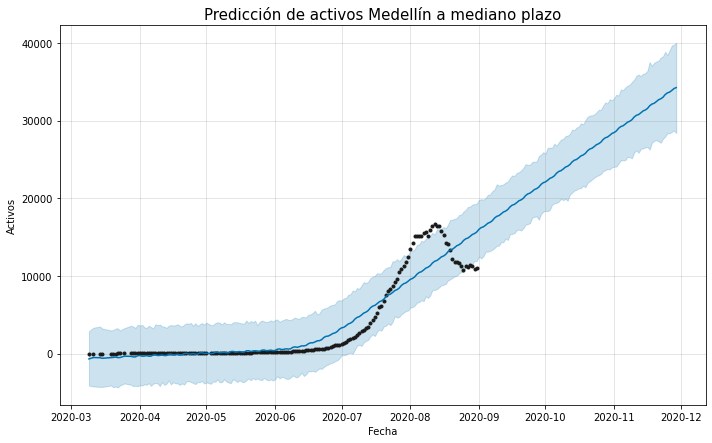

In [ ]:
# Activos
act_med_pred_medplaz, act_med_plot_medplaz, act_med_r2_medplaz, act_med_mse_medplaz, act_med_mae_medplaz = predictor_ts(df_med_sum_cases, 'activos', "Medellín", "mediano plazo", perds)

In [ ]:
act_med_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
246,2020-11-20,32449.197658,27493.712768,37617.911794
247,2020-11-21,32693.875405,27344.220648,37713.754725
248,2020-11-22,32814.402236,27167.793173,38139.853346
249,2020-11-23,33016.447147,27666.148754,38265.516702
250,2020-11-24,33360.188129,27945.530785,38881.550530
251,2020-11-25,33580.315622,28412.604067,38439.926041
252,2020-11-26,33680.752299,28374.255789,39052.095230
253,2020-11-27,33894.889605,28559.584783,39677.183176
254,2020-11-28,34139.567352,28724.675687,39785.256333
255,2020-11-29,34260.094183,28403.038850,40050.811979


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Medellín para los próximos 90 días es:
El r2 es:  0.7809284581470552
El MSE es:  37071.91672736671
El MAE es:  119.34470816090001


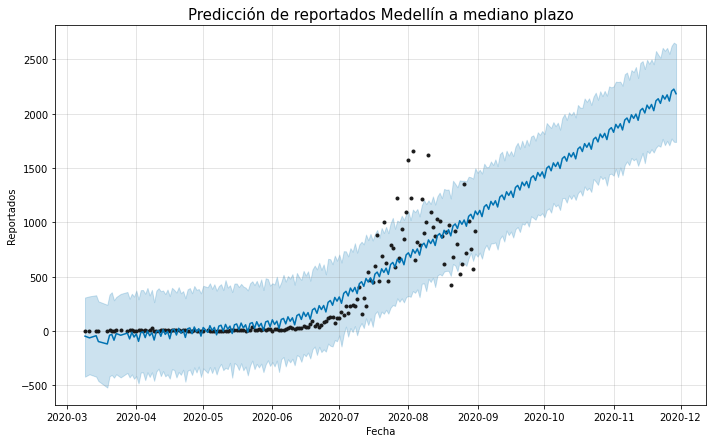

In [ ]:
# Reportados
rep_med_pred_medplaz, rep_med_plot_medplaz, rep_med_r2_medplaz, rep_med_mse_medplaz, rep_med_mae_medplaz = predictor_ts(df_med_sum_cases, 'reportados', "Medellín", "mediano plazo", perds)

In [ ]:
rep_med_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
246,2020-11-20,2119.631623,1688.406188,2578.195391
247,2020-11-21,2138.625809,1709.878691,2543.718734
248,2020-11-22,2095.902090,1697.325348,2515.564167
249,2020-11-23,2168.561015,1769.348574,2607.114889
250,2020-11-24,2135.018652,1711.299213,2579.891746
251,2020-11-25,2174.581350,1750.411730,2606.336767
252,2020-11-26,2117.216548,1710.030782,2551.533258
253,2020-11-27,2208.236188,1772.346828,2625.607982
254,2020-11-28,2227.230373,1743.050746,2654.823781
255,2020-11-29,2184.506655,1740.208493,2642.176213


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Medellín para los próximos 90 días es:
El r2 es:  0.8350027930753764
El MSE es:  25706.08031973213
El MAE es:  81.16595456905746


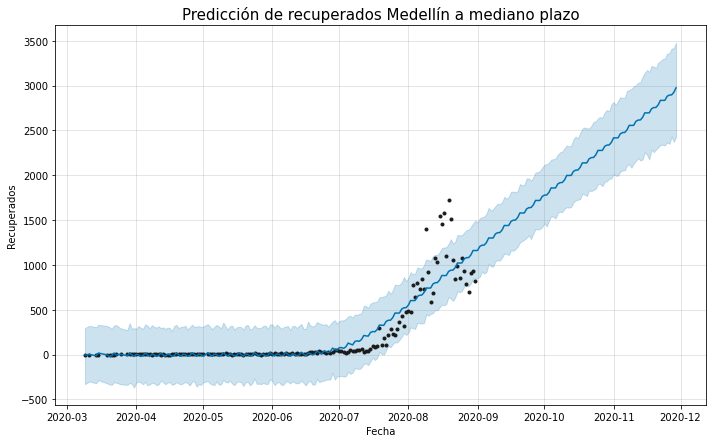

In [ ]:
# Recuperados
rec_med_pred_medplaz, rec_med_plot_medplaz, rec_med_r2_medplaz, rec_med_mse_medplaz, rec_med_mae_medplaz = predictor_ts(df_med_sum_cases, 'recuperados', "Medellín", "mediano plazo", perds)

In [ ]:
rec_med_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
246,2020-11-20,2757.000731,2287.303456,3196.025080
247,2020-11-21,2785.654750,2311.764027,3255.499908
248,2020-11-22,2836.380401,2337.376476,3274.613447
249,2020-11-23,2835.353130,2340.998795,3297.387396
250,2020-11-24,2836.594575,2333.499135,3302.559149
251,2020-11-25,2881.188917,2368.280753,3356.766369
252,2020-11-26,2895.064416,2350.989015,3362.446132
253,2020-11-27,2896.549087,2430.528042,3412.949082
254,2020-11-28,2925.203106,2373.951332,3419.008167
255,2020-11-29,2975.928757,2428.291965,3479.589981


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Medellín para los próximos 90 días es:
El r2 es:  0.8409057851227898
El MSE es:  11.741425566536686
El MAE es:  2.073849368403279


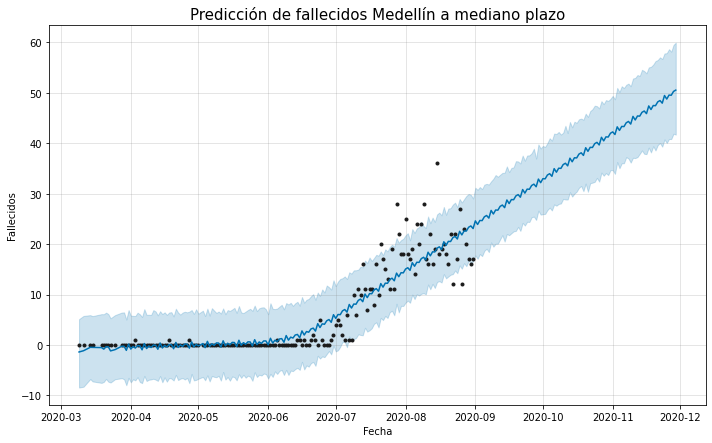

In [ ]:
# Fallecidos
fall_med_pred_medplaz, fall_med_plot_medplaz, fall_med_r2_medplaz, fall_med_mse_medplaz, fall_med_mae_medplaz = predictor_ts(df_med_sum_cases, 'fallecidos', "Medellín", "mediano plazo",  perds)

In [ ]:
fall_med_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
246,2020-11-20,47.465169,38.575736,56.310073
247,2020-11-21,48.218338,39.645803,56.523435
248,2020-11-22,48.481747,40.057858,57.058525
249,2020-11-23,47.959562,39.328460,56.723264
250,2020-11-24,49.485239,40.774144,57.822771
251,2020-11-25,48.773337,40.062838,57.883438
252,2020-11-26,49.566728,40.862703,58.672014
253,2020-11-27,49.537963,40.844030,58.181742
254,2020-11-28,50.291132,41.894831,59.514268
255,2020-11-29,50.554541,41.727276,59.969392


####3.1.2.4 Cali

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Cali para los próximos 90 días es:
El r2 es:  0.9602475819179361
El MSE es:  418374.8874318951
El MAE es:  346.5867992351487


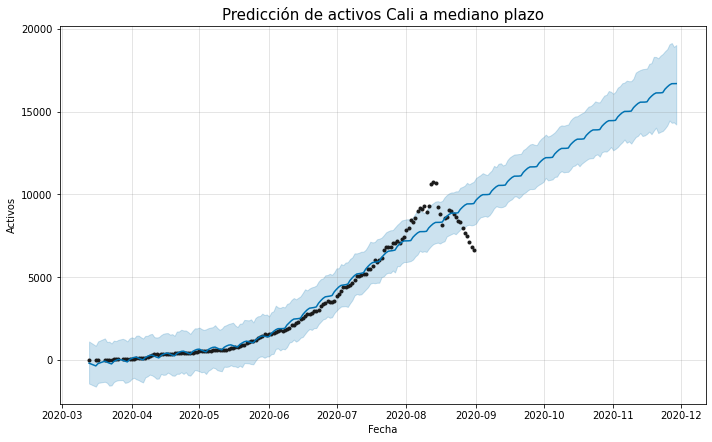

In [ ]:
# Activos
act_cal_pred_medplaz, act_cal_plot_medplaz, act_cal_r2_medplaz, act_cal_mse_medplaz, act_cal_mae_medplaz = predictor_ts(df_cal_sum_cases, 'activos', "Cali", "mediano plazo", perds)


In [ ]:
act_cal_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
247,2020-11-20,16127.163328,14027.604263,18301.224652
248,2020-11-21,16127.588579,13704.661191,18220.420646
249,2020-11-22,16132.742702,13774.576189,18377.784439
250,2020-11-23,16149.752566,13828.731641,18481.090778
251,2020-11-24,16354.199095,13978.905752,18643.337104
252,2020-11-25,16491.607581,14159.659015,18772.888177
253,2020-11-26,16609.215079,14458.596984,19063.922953
254,2020-11-27,16685.708946,14323.040319,19141.979121
255,2020-11-28,16686.134197,14347.483570,18907.446330
256,2020-11-29,16691.288320,14221.678321,19022.361883


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Cali para los próximos 90 días es:
El r2 es:  0.6940630173912306
El MSE es:  19531.74330268846
El MAE es:  84.64644357202609


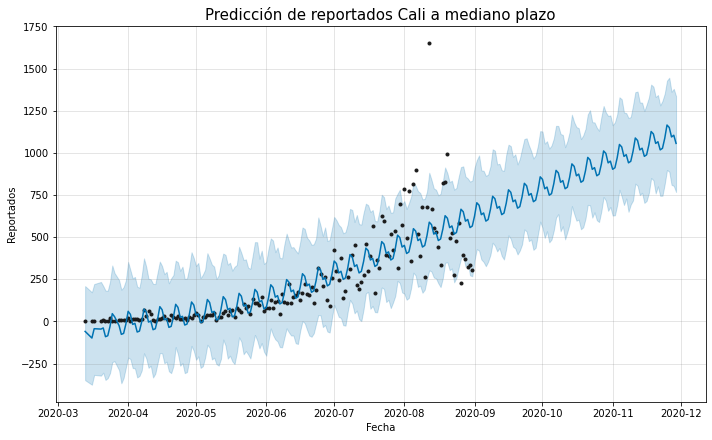

In [ ]:
# Reportados
rep_cal_pred_medplaz, rep_cal_plot_medplaz, rep_cal_r2_medplaz, rep_cal_mse_medplaz, rep_cal_mae_medplaz = predictor_ts(df_cal_sum_cases, 'reportados', "Cali", "mediano plazo", perds)

In [ ]:
rep_cal_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
247,2020-11-20,1056.108052,759.508384,1331.135503
248,2020-11-21,1066.217141,801.430764,1343.274302
249,2020-11-22,1017.961782,745.311623,1281.586661
250,2020-11-23,1027.157890,746.152270,1308.515724
251,2020-11-24,1086.159309,815.253809,1351.844347
252,2020-11-25,1165.252311,898.937420,1428.602155
253,2020-11-26,1150.600740,888.062434,1445.919577
254,2020-11-27,1094.524909,810.588649,1362.402150
255,2020-11-28,1104.633999,804.361550,1379.939813
256,2020-11-29,1056.378640,767.915345,1336.757709


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Cali para los próximos 90 días es:
El r2 es:  0.7533586330660389
El MSE es:  15667.994492571344
El MAE es:  52.08976236690379


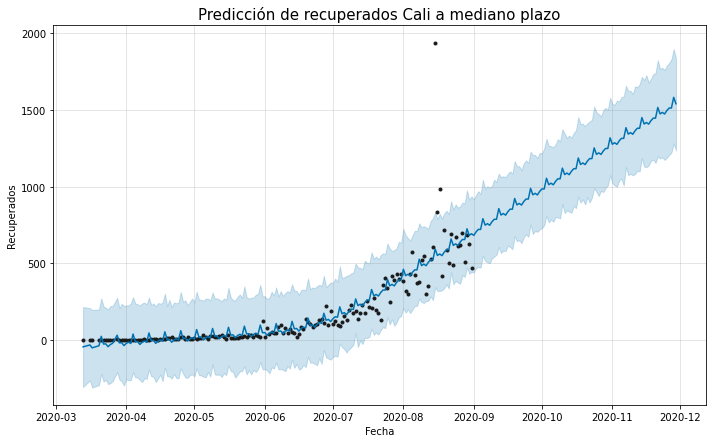

In [ ]:
# Recuperados
rec_cal_pred_medplaz, rec_cal_plot_medplaz, rec_cal_r2_medplaz, rec_cal_mse_medplaz, rec_cal_mae_medplaz = predictor_ts(df_cal_sum_cases, 'recuperados', "Cali", "mediano plazo", perds)

In [ ]:
rec_cal_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
247,2020-11-20,1447.331695,1155.068463,1740.674647
248,2020-11-21,1517.271907,1198.609393,1826.294230
249,2020-11-22,1475.258271,1184.543277,1768.903503
250,2020-11-23,1484.931858,1191.950438,1775.530577
251,2020-11-24,1474.470313,1175.012663,1761.440534
252,2020-11-25,1497.052143,1189.626009,1789.645946
253,2020-11-26,1513.616307,1207.481474,1807.845953
254,2020-11-27,1513.304091,1223.382466,1831.148895
255,2020-11-28,1583.244304,1282.371029,1898.204413
256,2020-11-29,1541.230668,1236.488643,1837.956808


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Cali para los próximos 90 días es:
El r2 es:  0.7306317094370409
El MSE es:  15.610283127906305
El MAE es:  2.958193367006446


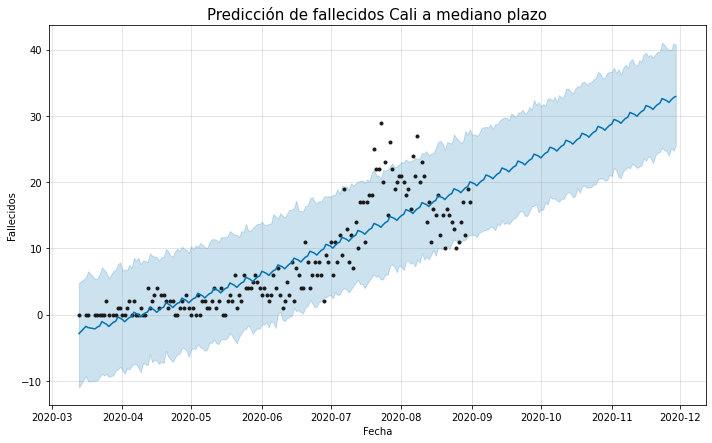

In [ ]:
# Fallecidos
fall_cal_pred_medplaz, fall_cal_plot_medplaz, fall_cal_r2_medplaz, fall_cal_mse_medplaz, fall_cal_mae_medplaz = predictor_ts(df_cal_sum_cases, 'fallecidos', "Cali", "mediano plazo", perds)

In [ ]:
fall_cal_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
247,2020-11-20,31.374812,23.960828,39.304849
248,2020-11-21,31.710397,24.430986,39.661491
249,2020-11-22,31.896422,24.565854,39.657359
250,2020-11-23,32.614599,25.207344,41.059121
251,2020-11-24,32.471395,24.817886,40.723176
252,2020-11-25,32.317643,24.701493,40.266394
253,2020-11-26,32.029351,24.010426,39.956657
254,2020-11-27,32.421930,25.167756,39.970416
255,2020-11-28,32.757515,24.761313,40.940431
256,2020-11-29,32.943541,25.496548,40.727430


####3.1.2.5 Barranquilla

**Activos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos activos de COVID en Barranquilla para los próximos 90 días es:
El r2 es:  0.9899552751663842
El MSE es:  104064.97680066028
El MAE es:  208.01469537750432


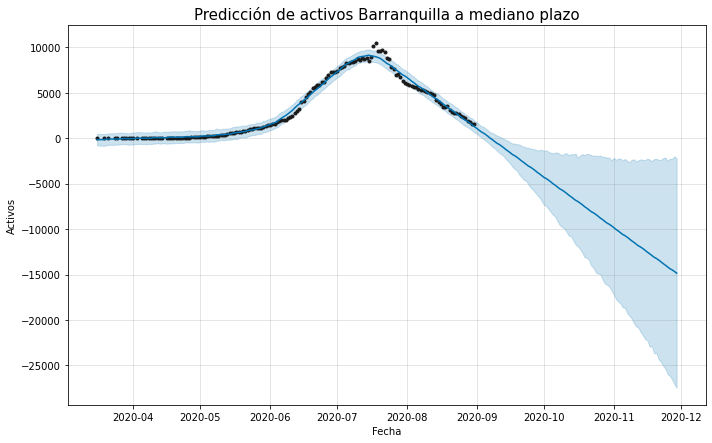

In [ ]:
# Activos
act_bar_pred_medplaz, act_bar_plot_medplaz, act_bar_r2_medplaz, act_bar_mse_medplaz, act_bar_mae_medplaz = predictor_ts(df_bar_sum_cases, 'activos', "Barranquilla", "mediano plazo", perds)

In [ ]:
 act_bar_pred.tail(10)

,ds,yhat,yhat_lower,yhat_upper
165,2020-09-06,212.057407,-428.689961,920.107418
166,2020-09-07,6.339858,-712.417486,715.628725
167,2020-09-08,-165.164569,-893.474055,604.073789
168,2020-09-09,-352.821838,-1120.999529,452.908663
169,2020-09-10,-552.594618,-1295.090432,228.679965
170,2020-09-11,-681.796762,-1483.227233,204.471911
171,2020-09-12,-853.663098,-1698.905992,71.394422
172,2020-09-13,-1042.970185,-2009.371842,-62.635914
173,2020-09-14,-1248.687734,-2274.109901,-218.713175
174,2020-09-15,-1420.192161,-2495.022073,-312.159070


**Reportados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos reportados de COVID en Barranquilla para los próximos 90 días es:
El r2 es:  0.5058513568473888
El MSE es:  37342.351069180244
El MAE es:  111.59432984284929


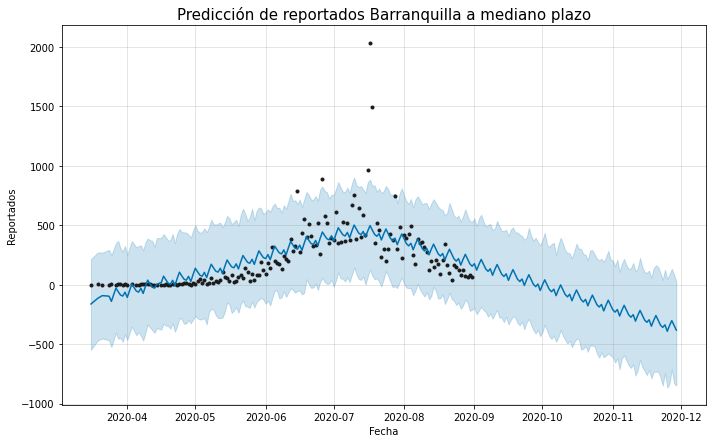

In [ ]:
# Reportados
rep_bar_pred_medplaz, rep_bar_plot_medplaz, rep_bar_r2_medplaz, rep_bar_mse_medplaz, rep_bar_mae_medplaz = predictor_ts(df_bar_sum_cases, 'reportados', "Barranquilla", "mediano plazo", perds)

In [ ]:
rep_bar_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
240,2020-11-20,-258.175601,-729.998830,164.075443
241,2020-11-21,-299.375699,-730.866950,150.697035
242,2020-11-22,-338.389571,-778.093681,99.237434
243,2020-11-23,-358.305477,-847.098424,42.508482
244,2020-11-24,-336.719753,-741.212195,126.799762
245,2020-11-25,-391.247316,-864.290870,49.201106
246,2020-11-26,-343.086393,-831.310623,86.806409
247,2020-11-27,-301.049413,-711.621972,134.549201
248,2020-11-28,-342.249512,-827.094432,86.773876
249,2020-11-29,-381.263384,-847.998489,26.053877


**Recuperados:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos recuperados de COVID en Barranquilla para los próximos 90 días es:
El r2 es:  0.47943068219875606
El MSE es:  35945.225154547894
El MAE es:  128.6652599332637


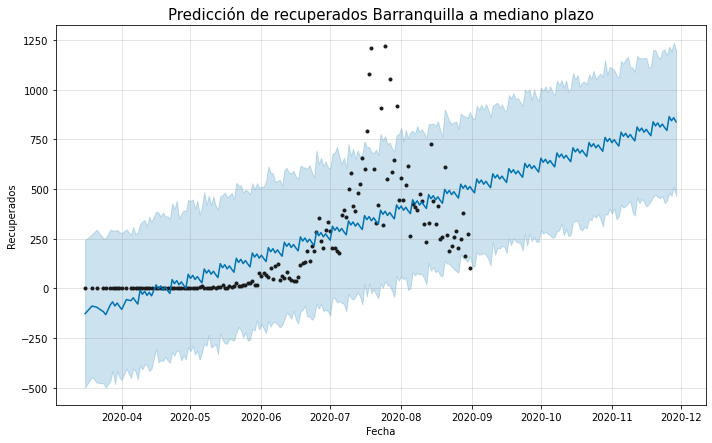

In [ ]:
# Recuperados
rec_bar_pred_medplaz, rec_bar_plot_medplaz, rec_bar_r2_medplaz, rec_bar_mse_medplaz, rec_bar_mae_medplaz = predictor_ts(df_bar_sum_cases, 'recuperados', "Barranquilla", "mediano plazo", perds)

In [ ]:
rec_bar_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
240,2020-11-20,818.129118,472.686761,1199.627137
241,2020-11-21,833.364215,459.812869,1169.236589
242,2020-11-22,812.323365,453.910868,1155.101742
243,2020-11-23,827.179885,465.200685,1196.679819
244,2020-11-24,809.971744,430.346191,1202.928941
245,2020-11-25,795.127351,441.600941,1171.878020
246,2020-11-26,865.065123,479.282730,1217.756737
247,2020-11-27,844.295468,466.998900,1192.691450
248,2020-11-28,859.530565,511.814917,1237.257888
249,2020-11-29,838.489715,464.556015,1197.749885


**Fallecidos:**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


La predicción de casos fallecidos de COVID en Barranquilla para los próximos 90 días es:
El r2 es:  0.6762477088955801
El MSE es:  46.64036209204856
El MAE es:  5.459478963265513


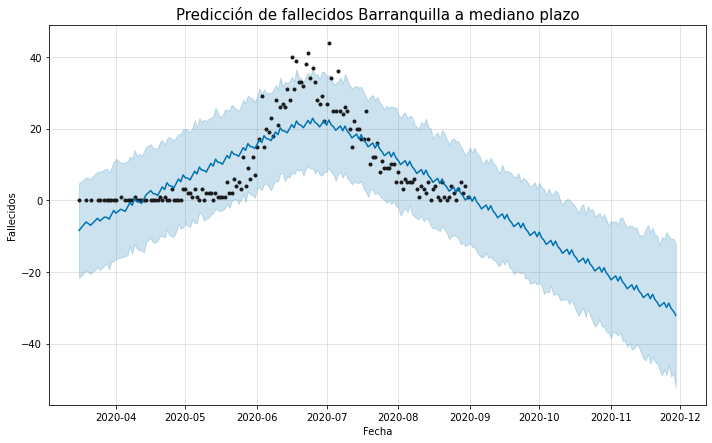

In [ ]:
# Fallecidos
fall_bar_pred_medplaz, fall_bar_plot_medplaz, fall_bar_r2_medplaz, fall_bar_mse_medplaz, fall_bar_mae_medplaz = predictor_ts(df_bar_sum_cases, 'fallecidos', "Barranquilla", "mediano plazo", perds)

In [ ]:
fall_bar_pred_medplaz.tail(10)

,ds,yhat,yhat_lower,yhat_upper
240,2020-11-20,-27.747744,-45.046850,-9.754174
241,2020-11-21,-28.507111,-45.542251,-9.851702
242,2020-11-22,-29.650459,-47.360717,-12.640076
243,2020-11-23,-29.090350,-48.928177,-10.198878
244,2020-11-24,-28.556910,-47.147370,-11.049537
245,2020-11-25,-29.975699,-48.721475,-8.888923
246,2020-11-26,-28.728177,-46.045342,-10.143392
247,2020-11-27,-30.223114,-49.298816,-10.826381
248,2020-11-28,-30.982481,-48.104915,-10.704659
249,2020-11-29,-32.125829,-52.300228,-12.384060


# 4.  Gestión del ciclo de vida del producto de datos

Los datos fueron capturados a partir de la librería de python llamada  “sodapay”, la cual tiene una API  llamada  “Socrata” que alberga datos abiertos de diferentes gobiernos en el mundo, dentro de los cuales está Colombia. 
Esta API nos permite actualizar los datos en tiempo real en el notebook de colab y utilizarlos como un dataframe, para graficarlos, hacer los análisis estadísticos y aplicar el modelo predictivo.
Para los datos faltantes no se tiene un método en específico.


#5. Resultados


*   Corto plazo: Entre los tipos de casos, los activos, son los que tienen mayor error MSE y MAE, mientras que, en el caso de los fallecidos, tanto el MSE como el MAE son los más bajos. El R2 se ajusta de mejor manera en los casos de tipo activos.
Comparando las ciudades, Barranquilla es la que mejor se ajusta a las prediccones de forma general.



*   Mediano plazo: Entre los tipos de casos, los activos, son los que tienen mayor error MSE y MAE, mientras que, en el caso de los fallecidos, tanto el MSE como el MAE son los más bajos. 
El R2 se ajusta de mejor manera en los casos de tipo activos y para los casos de Colombia se ajusta bastante bien.
A diferencia del corto plazo, las predicciones en Barranquilla van perdiendo confiabilidad, debido a que el intervalo de confianza se vuelve negativo y el ajuste del R2 disminuye considerablemente.

*  Mediano y corto plazo: Observamos que las predicciones se comportan mejor a corto que a mediano plazo en cada una de las ciudades. En Colombia, las predicciones se comportan de forma parecida, notandose una disminución en el intervalo de confianza en el mediano plazo en comparación con el corto plazo.

#6. Conclusiones

Según las predicciones, los casos de COVID19 aumentarán en los siguientes días, a excepción de la ciudad de Barranquilla. Esto es debido a que en esta ciudad el pico llegó antes que en las demás ciudades, por lo tanto, las predicciones en Barranquilla son decrecientes, es decir, se presenta una disminución de casos en los días posteriores al 31 de agosto. 
Para el caso de Colombia, se da un aumento de casos de activos, recuperados y reportados en las predicciones, sin embargo, se da una disminución en el caso de fallecidos. 
Las predicciones en toda Colombia se ajustan a lo que habíamos pensado incialmente, sin embargo, esto no pasa cuando se observa el comportamiento de cada ciudad.





#7. Bibliografía



* Edureka!. (2020, 29 de marzo). COVID - 19 Outbreak Prediction using Machine Learning | Machine Learning Training | Edureka [Video]. YouTube. https://www.youtube.com/watch?v=_Hi6_JQesSQ.

* Facebook. Prophet. Tomado de: https://facebook.github.io/prophet/

* Facebook. Prophet documentation. Tomado de: https://facebook.github.io/prophet/docs/

* Facebook. Prophet code. Tomado de: https://github.com/facebook/prophet

